# Visualizing Activations

The following notebook takes a look into the behavior of hidden layers in shallow, dense neural networks. Though neural networks are often referred to as black box methodologies, this notebook is a demonstration of the internal behavior of these black boxes and the structures that underpin these shallow, dense neural networks.

The notebook is broken up into five different sections. The first three sections are concerned with a shallow, dense neural network with a single hidden layer and are arranged as follows:

*Section 1* - A single hidden unit in the hidden layer

*Section 2* - Two hidden units in the hidden layer

*Section 3* - Varying numbers of hidden units in the hidden layer, ranging from 32 to 512

The fourth section of the notebook explores the impact on the behavior of the activation values when principal components analysis is used for dimensionality reduction. The fifth section of the notebook does essentially the same, but this time, a random forest model's feature importances are used to reduce the dimensionality of the data. 

All sections of this notebook make use of a **Fonts** dataset from the UCI Machine Learning Repository. The specific font under consideration is the *Times* font, and the dataset is formatted as a classification problem in which the two classes are 'Standard Font' and 'Italicized Font'. 

# Packages

In [ ]:
import requests
import zipfile
import pandas as pd
import io
import numpy as np
import tensorflow as tf

#graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

#graphics parameters
mpl.rcParams['font.family'] = 'serif'

tf.random.set_seed(1031)

# Data Loading and Preparation

The dataset used in this notebook is available from the UCI Machine Learning Repository at the below link. This particular zip file contains a number of different font datasets, and one of these datasets is selected for the following analysis. 

In [ ]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip'

r = requests.get(data_url)
zf = zipfile.ZipFile(io.BytesIO(r.content))
data = pd.read_csv(zf.open('TIMES.csv'))

cols_to_drop = [
                'font',
                'fontVariant',
                'm_label',
                'strength',
                'orientation',
                'm_top',
                'm_left',
                'originalH',
                'originalW',
                'h',
                'w'
]

data.drop(cols_to_drop, axis=1, inplace=True)

First, the data is shuffled, and then it is split into training and test sets.

In [ ]:
split = int(data.shape[0]*0.8)

data = data.sample(frac=1, random_state=1031)

train_data = data.iloc[:split]
test_data = data.iloc[split:]

print(f'Training Set Shape: {train_data.shape}')
print(f'Test Set Shape    : {test_data.shape}')

Training Set Shape: (10184, 401)
Test Set Shape    : (2546, 401)


The data is then normalized by dividing all pixel values by the maximum pixel value of 255.

In [ ]:
X_train = train_data.iloc[:,1:].values
X_train = X_train/255.

X_test = test_data.iloc[:,1:].values
X_test = X_test/255.

y_train = train_data.iloc[:,0].values
y_test = test_data.iloc[:,0].values

# Exploration

This portion of the notebook takes a look at the contents of the data under study. Label proportions for the training and test sets are visualized, as are a sample of images from the dataset. 

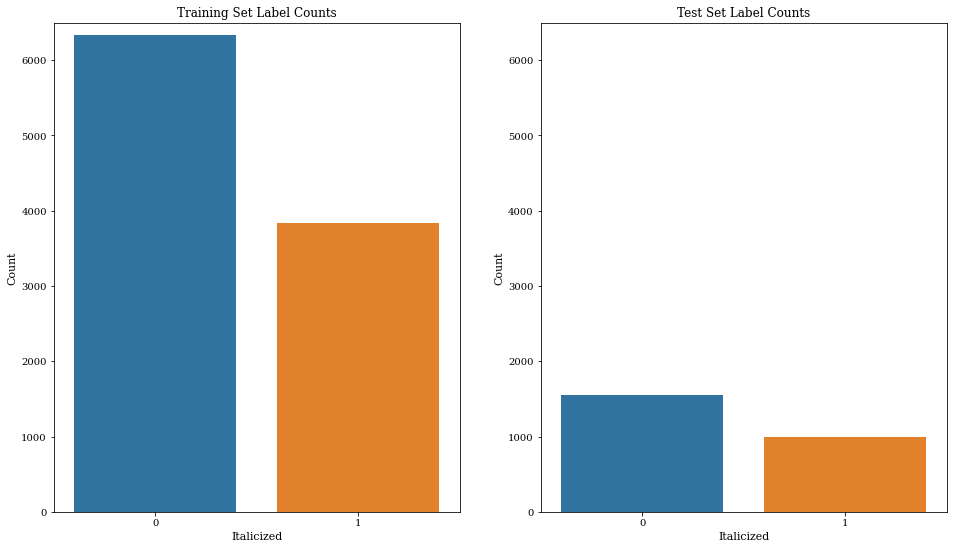

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(16,9))
axs = axs.flatten()

sns.countplot(x=train_data.italic, ax=axs[0])
axs[0].set_xlabel('Italicized',fontsize=11)
axs[0].set_ylabel('Count',fontsize=11)
axs[0].set_ylim([0,6500])
axs[0].set_title('Training Set Label Counts')

sns.countplot(x=test_data.italic, ax=axs[1])
axs[1].set_xlabel('Italicized',fontsize=11)
axs[1].set_ylabel('Count',fontsize=11)
axs[1].set_ylim([0,6500])
_ = axs[1].set_title('Test Set Label Counts')

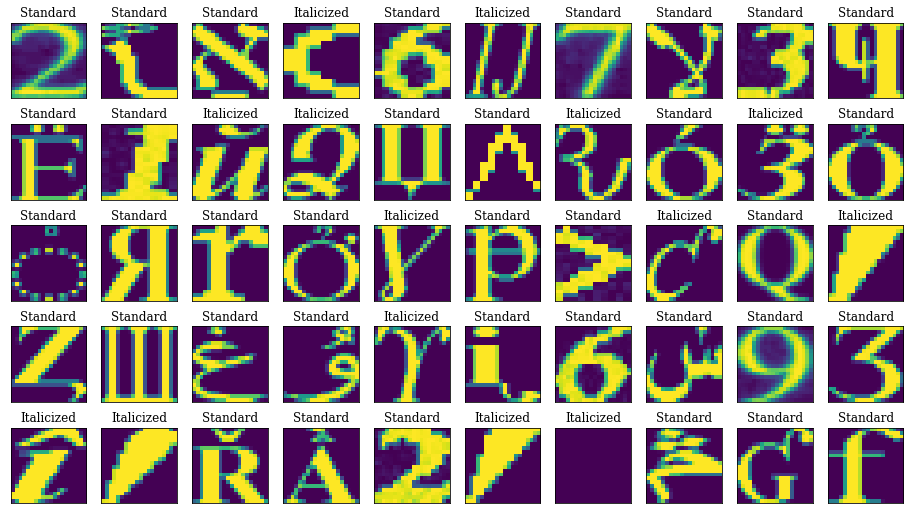

In [ ]:
# plotting sample of images from the training data and their labels -- 'Standard Font' or 'Italicized Font'
fig = plt.figure(figsize=(16,9))

for i in range(50):
  plt.subplot(5,10,i+1)
  if train_data.iloc[i,0] == 1:
    plt.title('Italicized')
  else:
    plt.title('Standard')
  plt.xticks([])
  plt.yticks([])
  plt.imshow(np.array(train_data.iloc[i,1:]).reshape(20,20))

In [ ]:
# 20x20 matrix view of an image in the training data with pixel values 
np.set_printoptions(linewidth=np.inf)
print('{}'.format(np.array(train_data.iloc[30,1:]).reshape(20,20)))

[[  1   1 144 255 255 255 241 173 173 173 173 173 199 255 255 255 255 255 217  47]
 [  1   1 144 255 198  36   4   1   1   1   1  23 219 255 255 255 255 255  57   1]
 [  1   4 176 153   4   1   1   1   1   1  20 211 255 255 255 255 255  69   1   1]
 [  1  13 204   6   1   1   1   1   1  17 162 255 255 255 255 255 121   1   1   1]
 [  1   6  46   1   1   1   1   1  15 154 255 255 255 255 255 131   2   1   1   1]
 [  1   1   1   1   1   1   1   1 128 255 255 255 255 255 172  14   1   1   1   1]
 [  1   1   1   1   1   1   1 115 248 255 255 255 255 207  17   1   1   1   1   1]
 [  1   1   1   1   1   1  64 246 255 255 255 255 212  35   1   1   1   1   1   1]
 [  1   1   1   1   1  56 244 255 255 255 255 242  58   1   1   1   1   1   1   1]
 [  1   1   1   1  37 210 255 255 255 255 244  66   1   1   1   1   1   1   1   1]
 [  1   1   1  13 205 255 255 255 255 246 116   1   1   1   1   1   1   1   1   1]
 [  1   1   9 177 255 255 255 255 248 125   1   1   1   1   1   1   1   1   1   1]
 [  

# Modeling

This portion of the notebook details model building and visualization of the models' activation values. First, a number of functions that will be repeatedly used are defined, as is an 'activation_model' class that will handle the majority of the activation values' interpretation. 

## Functions

In [ ]:
# plots a sample of images, their actual labels, and their predicted labels,
# and colors this information based on the quality of the prediction   
def plot_results(preds, y_rest):
  plt.figure(figsize=(24,12))

  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    col='g'
    if preds[i] == 0:
      pred='Standard'
    else: pred='Italicized'

    if y_test[i]==0:
      actual='Standard'
    else: actual='Italicized'

    if pred != actual:
      col='r'

    plt.xlabel(f'i={i} | pred={pred} | actual={actual}', color=col)
    plt.imshow(np.array(X_test[i]).reshape(20,20))

  plt.show()


# plots the training and validation accuracies and losses of the models
def fit_plots(history):
  epochs = len(list(history.history.values())[0])
  fig, axs = plt.subplots(1,2, figsize=(14,6))

  axs[0].plot(range(epochs), history.history['accuracy'], label='Training Accuracy')
  axs[0].plot(range(epochs), history.history['val_accuracy'], label='Validation Accuracy')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_title('Training & Validation Accuracy')
  axs[0].legend()

  axs[1].plot(range(epochs), history.history['loss'], label='Training Loss')
  axs[1].plot(range(epochs), history.history['val_loss'], label='Validation Loss')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Loss')
  axs[1].set_title('Training & Validation Loss')
  axs[1].legend()

  plt.show()

# plots a 20x20 heatmapped grid of a random forest model's feature importances results
def plot_heat_char(data):
  image = data.reshape(20,20)
  plt.imshow(image, cmap = 'hot', interpolation = 'nearest')
  plt.axis


def pair(n,size):
  x = n//size
  y = n%size
  return x,y  

## Classes

In [ ]:
# creates a class and accompanying methods that streamline the process of interpreting a model's activation values 
class activation_model:
  def __init__(self, model, preds, X_test, hidden_units):
    super(activation_model, self).__init__()
    self.model = model
    self.preds = preds
    self.X_test = X_test
    self.hidden_units = hidden_units

    layer_outputs = [layer.output for layer in model.layers]
    
    self.activation = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

    self.activations = self.activation.predict(self.X_test)
    self.hidden_layer_activation = self.activations[0]
    self.output_layer_activation = self.activations[1]

    self.activation_data = {'pred_class': self.preds}
    for i in range(self.hidden_units):
      self.activation_data[f'act_val_{i}'] = self.hidden_layer_activation[:,i]
    self.activation_data = pd.DataFrame(self.activation_data)

  # returns the maximum activation value in the dataset and the corresponding image's class
  def max_activations(self):
    print(f'The maximum activation value of the hidden node(s) in the hidden layer is {self.hidden_layer_activation.max()}.')
    
    if self.hidden_units > 2:
      standard_count=0
      italicized_count=0

      for i in range(self.activation_data.shape[1]-1):
        if len(self.activation_data[self.activation_data.iloc[:,i]==self.activation_data.iloc[:,i].max()].pred_class.values) > 1:
          standard_count+=1
          italicized_count=0
        else:
          if self.activation_data[self.activation_data.iloc[:,i]==self.activation_data.iloc[:,i].max()].pred_class.values == 0:
            standard_count+=1
          else:
            italicized_count+=1

      standard_pct = standard_count/(standard_count+italicized_count)
      italicized_pct = italicized_count/(standard_count+italicized_count)

      print(f'Percentage of Nodes Most Activated by Standard Class  : {round(standard_pct*100,2)}')
      print(f'Percentage of Nodes Most Activated by Italicized Class: {round(italicized_pct*100,2)}')
      
    elif self.hidden_units == 2:
      max_act_a = self.activation_data[self.activation_data.act_val_0==self.activation_data.act_val_0.max()].pred_class.values
      max_act_b = self.activation_data[self.activation_data.act_val_1==self.activation_data.act_val_1.max()].pred_class.values

      max_acts = ['Standard' if act == 0 else 'Italicized' for act in [max_act_a, max_act_b]]

      print(f"The first node is most activated by the '{max_acts[0]}' class.")
      print(f"The second node is most activated by the '{max_acts[1]}' class.")

    else:
      max_act = self.activation_data[self.activation_data.act_val_0==self.activation_data.act_val_0.max()].pred_class.values
      if max_act==0:
        max_class='Standard'
      else: max_class='Italicized'
      print(f"The corresponding class is '{max_class}'.")

  # creates boxplots of the activation values associated with the Standard and Italicized classes 
  def activations_boxplot(self, act_val):
    sns.boxplot(y=act_val, x='pred_class', data=self.activation_data, width=0.5, palette='colorblind')
    plt.xticks(ticks=[0,1], labels=['Standard','Italicized'])
    plt.xlabel('Font Style')
    plt.ylabel('Activation Values')
    plt.title("Box Plot of Each Class' Activation Values", weight='bold')
  
  # creates a scatterplot of the activation values for a given model in which the points are colored by actual label
  def activations_scatterplot(self, act_val_1, act_val_2):
    plt.figure(figsize=(16,10))
    sns.scatterplot(x=act_val_1,y=act_val_2, hue='pred_class', palette=sns.color_palette('hls', 2), data=self.activation_data, legend='full', alpha=0.3)
    plt.xlabel('Node 1 Activation')
    plt.ylabel('Node 2 Activation')
    plt.title('Activations of Hidden Layer')

  # for model's with more 2 or more units in their hidden layers
  # reduces the dimensionality of the nodes to 2 or 3 layers and creates a scatter plot of the result
  # points are colored by class label 
  def activations_pca_plot(self, dim=2):
    pca = PCA(n_components=dim)
    principalComponents = pca.fit_transform(self.activation_data.iloc[:,1:])
    principalDf = pd.DataFrame(principalComponents, columns=[f'principal component {i+1}' for i in range(dim)])

    activation_pca = pd.concat([principalDf, self.activation_data.pred_class], axis=1)

    colors = ['k','red']

    fig = plt.figure(figsize=(16,10))

    if dim==2:
      ax = fig.add_subplot(111)
      x = activation_pca['principal component 1']
      y = activation_pca['principal component 2']

      ax.set_xlabel('Principal Component 1')
      ax.set_ylabel('Principal Component 2')

      ax.set_title('2-Component PCA')

      ax.scatter(x, y, c=activation_pca['pred_class'].apply(lambda x: colors[x]), alpha=0.3)

    if dim==3:
      ax = fig.add_subplot(111, projection='3d')
      x = activation_pca['principal component 1']
      y = activation_pca['principal component 2']
      z = activation_pca['principal component 3']

      ax.set_xlabel('Principal Component 1')
      ax.set_ylabel('Principal Component 2')
      ax.set_zlabel('Principal Component 3')

      ax.set_title('3-Component PCA')

      ax.scatter(x, y, z, c=activation_pca['pred_class'].apply(lambda x: colors[x]), alpha=0.3)

## Section 1

The first section of this notebook depicts the behavior of a model with a single hidden unit. The model is built and then trained on the training split of the data. It's quality is evaluated both graphically and on the unseen test split. The output class associated with the highest activation value in this single hidden unit is determined, and boxplots of the activation values associated with each class are also created. 

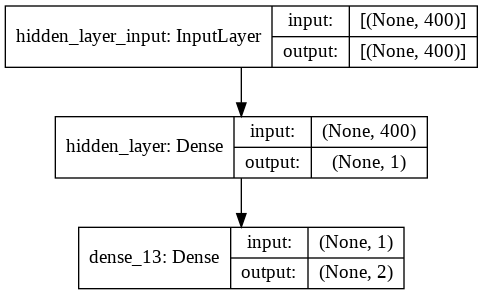

In [ ]:
model_1 = tf.keras.Sequential([
                             tf.keras.layers.Dense(1, activation='relu', input_shape=(400,), name='hidden_layer'),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model_1, show_shapes=True)

In [ ]:
model_1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 1)                 401       
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 4         
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_1.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.2, verbose=False)
preds = [np.argmax(p) for p in model_1.predict(X_test)]
loss, accuracy = model_1.evaluate(X_test, y_test)
print(f'Test Set Accuracy: {round(accuracy*100, 2)}')

80/80 [==============================] - 0s 2ms/step - loss: 0.4100 - accuracy: 0.8401
Test Set Accuracy: 84.01


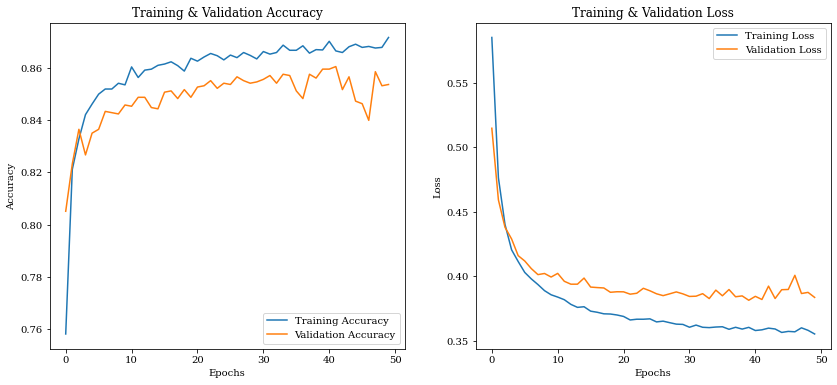

In [ ]:
fit_plots(history)

The model achieves just over 84% accuracy on the test set, which is considerably high for a network with only a single hidden unit and 405 trainable parameters. The above plots show that the model begins to overfit just slightly at around the 10th epoch, though the validation loss plateaus more obviously than does the validation accuracy. 

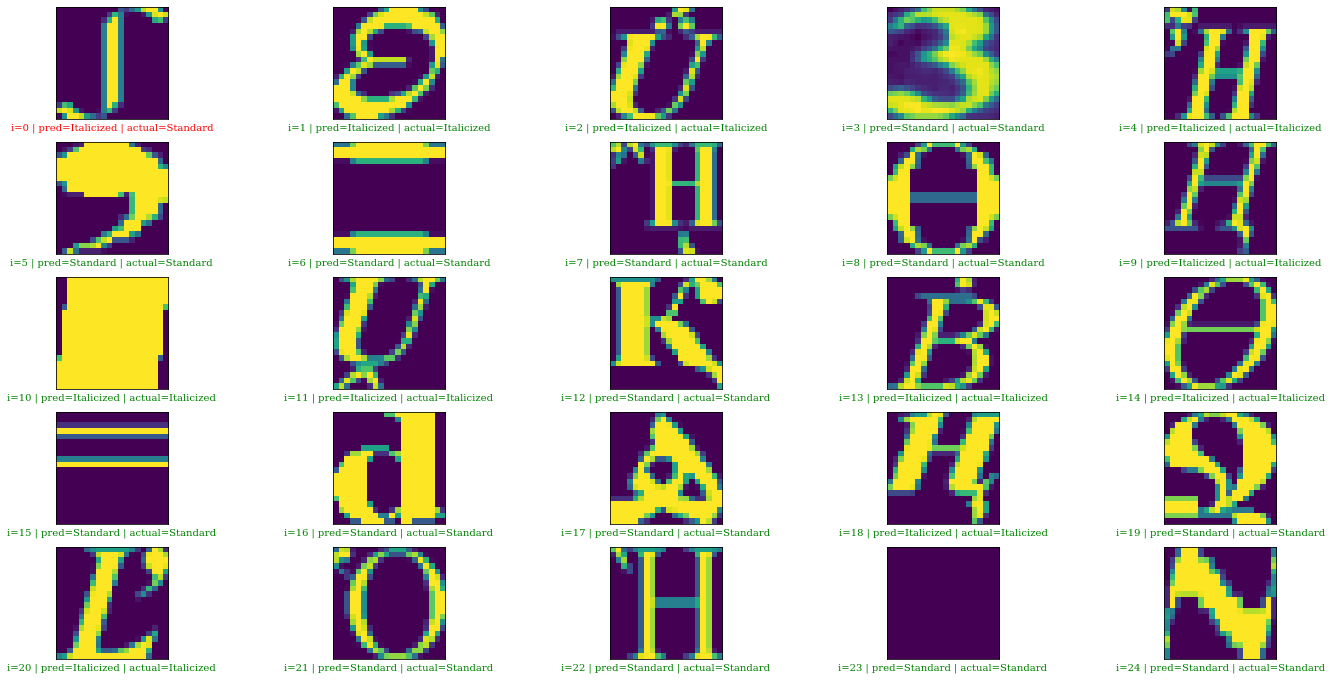

In [ ]:
plot_results(preds, y_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      1551
           1       0.88      0.69      0.77       995

    accuracy                           0.84      2546
   macro avg       0.85      0.81      0.82      2546
weighted avg       0.84      0.84      0.84      2546



In the sampling of images above, Image 0 is the only image to have been labeled incorrectly. While the images in the *Italicized* class tend to have diagonal lines in them running from bottom left to top right, this image lacks that. What it does have is two areas in the bottom left and top right with considerable curvature, so it is likely that the model mistook these areas as being representative of an italicized font. Overall, the model has a far easier time of recalling images in the *Standard* class than in the *Italicized* class, even though the precision of the *Italicized* class is a bit higher. This indicates too rigorous of a learning of the *Standard* class' features.


This next part of the section creates the activation model and digs into the activation values.

In [ ]:
am = activation_model(model_1, preds, X_test, 1)
am.max_activations()

The maximum activation value of the hidden node(s) in the hidden layer is 4.773839950561523.
The corresponding class is 'Italicized'.


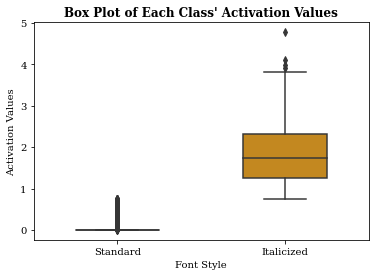

In [ ]:
am.activations_boxplot('act_val_0')

The boxplot shows that the images in the *Italicized* class activate the hidden unit to a greater extent than do the images in the *Standard* class. The majority of images in that class have activation values at or barely above 0, whereas the majority of activation values in the *Italicized* class fall somewhere between 1 and 2. Thus it appears that the activation threshold for an image to be classified as *Italicized* is just slightly too high, amounting to the poorer recall in the classification report above.  

## Section 2

Section 2 considers the case of a single hidden layer with two hidden units as opposed to just one. In addition to the visualizations from Section 1, Section 2 includes a 2D plot of the activation values coming from these two hidden units.

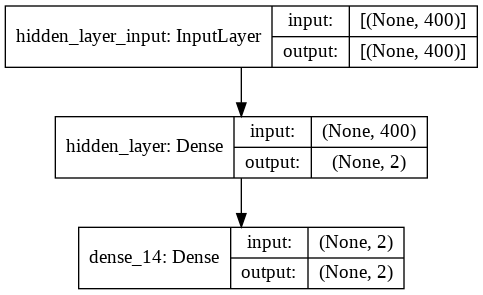

In [ ]:
model_2 = tf.keras.Sequential([
                             tf.keras.layers.Dense(2, activation='relu', input_shape=(400,), name='hidden_layer'),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model_2, show_shapes=True)

In [ ]:
history = model_2.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.2, verbose=False)
preds = [np.argmax(p) for p in model_2.predict(X_test)]
loss, accuracy = model_2.evaluate(X_test, y_test)
print(f'Test Set Accuracy: {round(accuracy*100, 2)}')

80/80 [==============================] - 0s 1ms/step - loss: 0.4175 - accuracy: 0.8331
Test Set Accuracy: 83.31


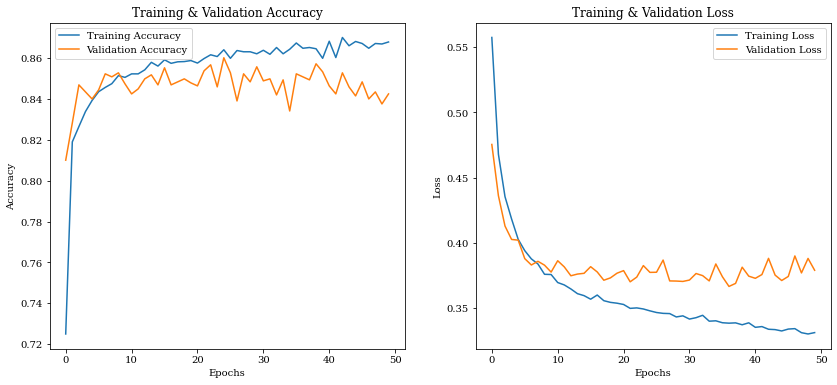

In [ ]:
fit_plots(history)

With a second hidden unit in the single hidden layer, the model's test accuracy actually falls off by a little less than 1%. As was the case with the previous model, the overfitting starts to kick in at around the 10th epoch. This time, though, the model's validation accuracy starts to suffer come the 50th epoch, unlike the initial model. 

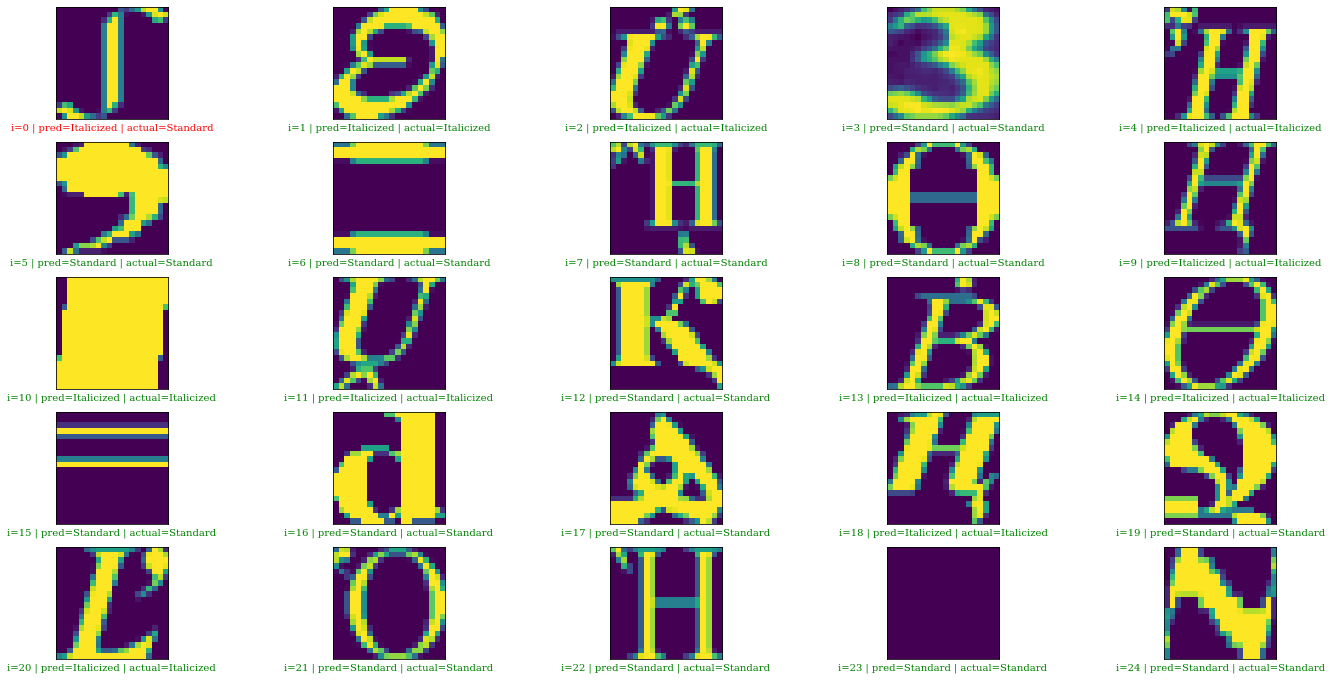

In [ ]:
plot_results(preds, y_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1551
           1       0.79      0.78      0.79       995

    accuracy                           0.83      2546
   macro avg       0.82      0.82      0.82      2546
weighted avg       0.83      0.83      0.83      2546



Again, the model struggles with the same image as before. The behavior of the model's precision and recall scores has changed quite a bit here, too. Recall of the *Standard* class has actually dropped off quite a bit while it has increased substantially for the *Italicized* class. The opposite appears to be true when it comes to the classes' precision scores. It seems that the model has found a better balance between precision and recall for the two classes; it excels with respect to neither class, but the approach is more consistent than that of the previous model.

In [ ]:
am = activation_model(model_2, preds, X_test, 2)
am.max_activations()

The maximum activation value of the hidden node(s) in the hidden layer is 6.918722629547119.
The first node is most activated by the 'Standard' class.
The second node is most activated by the 'Standard' class.


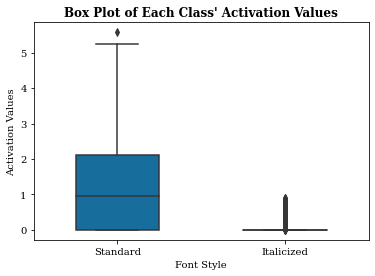

In [ ]:
am.activations_boxplot('act_val_0')

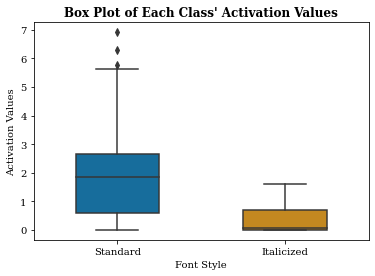

In [ ]:
am.activations_boxplot('act_val_1')

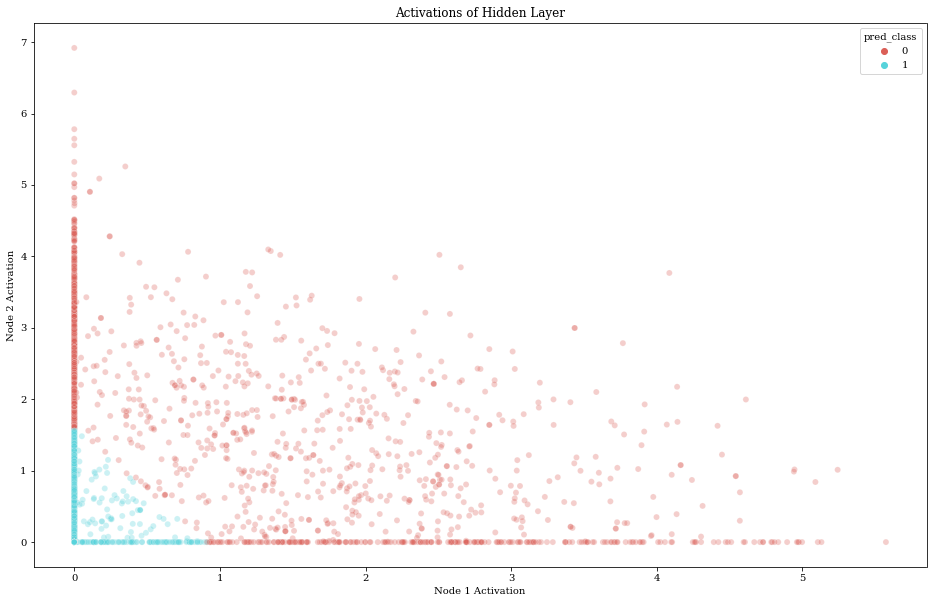

In [ ]:
am.activations_scatterplot('act_val_0','act_val_1')

The boxplots show that the *Standard* class tends to activate both nodes more than the *Italicized* class, which almost does not activate the first node at all. The scatterplot of activation values coming from both hidden units depicts much of the same -- activation values from the *Italicized* class find themselves at roughly 1 to 1.5 or below, whereas the activation values from the *Standard* class extend much farther beyond that. It appears that the vertical lines often present in the *Standard* class, as opposed to diagonal ones more frequent in the *Italicized* class, represent that pattern that activates the hidden units the most.   

## Section 3

Section 3 goes beyond Section 1 and Section 2 by introducing far more than just two hidden units into the single layer. Layer sizes between 32 and 512 are explored, and the activation values coming from these units are projected down to two dimensions with principal components analysis.

### Part 1

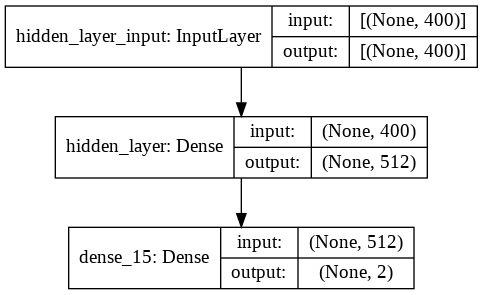

In [ ]:
model_3 = tf.keras.Sequential([
                             tf.keras.layers.Dense(512, activation='relu', input_shape=(400,), name='hidden_layer'),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model_3, show_shapes=True)

In [ ]:
history = model_3.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.2, verbose=False)
preds = [np.argmax(p) for p in model_3.predict(X_test)]
loss, accuracy = model_3.evaluate(X_test, y_test)
print(f'Test Set Accuracy: {round(accuracy*100, 2)}')

80/80 [==============================] - 0s 1ms/step - loss: 0.3284 - accuracy: 0.9132
Test Set Accuracy: 91.32


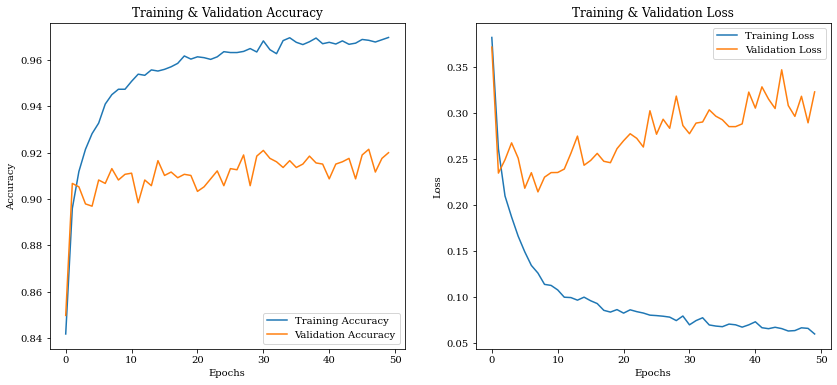

In [ ]:
fit_plots(history)

The use of 512 hidden units in the single hidden layer, as opposed to just one or two hidden units, dramatically increases the capacity of the model. The model's test increased by nearly 10%, from 83.31% in the previous model to 91.32% here. However, with that increased capacity comes a greater risk of overfitting, which is exactly what has occurred. Whereas previous models took about 10 epochs to start overfitting, this model overfits almost immediately and improves very little with longer training.

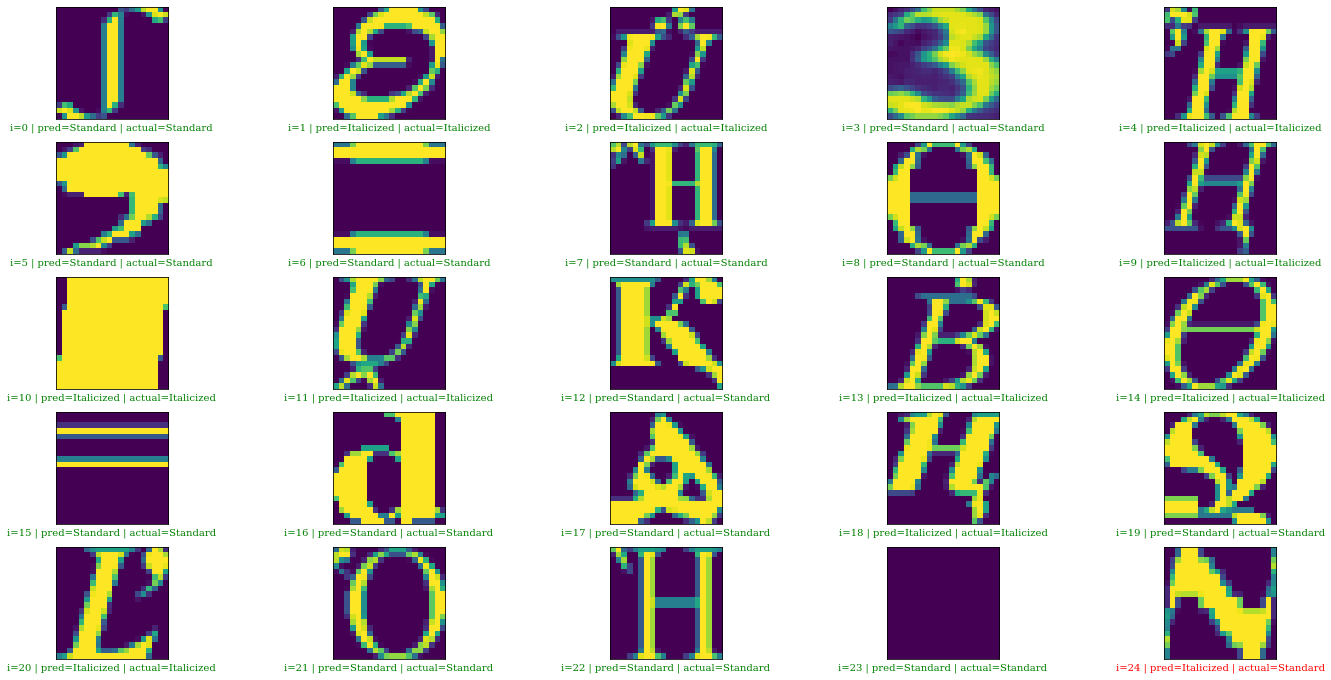

In [ ]:
plot_results(preds, y_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1551
           1       0.91      0.87      0.89       995

    accuracy                           0.91      2546
   macro avg       0.91      0.90      0.91      2546
weighted avg       0.91      0.91      0.91      2546



This model is the first to predict Image 0 and Image 4 correctly, and the only image that it predicts incorrectly in the image above is Image 24. This image is neat in that it has two sets of diagonal lines - one set is much thinner and moves bottom left to top right, while the other has a more drawn out slope and moves top left to bottom right.

The model's precision and recall scores are also quite good, yet these metrics as they pertain to the *Standard* class are still a bit higher than they are for the *Italicized* class, indicating that the model has had an easier time of learning the former class' features. 

In [ ]:
am = activation_model(model_3, preds, X_test, 512)
am.max_activations()

The maximum activation value of the hidden node(s) in the hidden layer is 12.039738655090332.
Percentage of Nodes Most Activated by Standard Class  : 100.0
Percentage of Nodes Most Activated by Italicized Class: 0.0


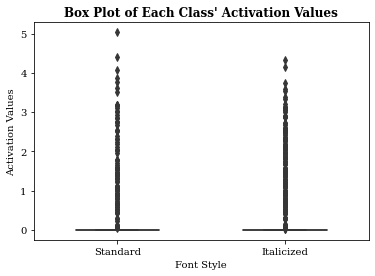

In [ ]:
am.activations_boxplot('act_val_0')

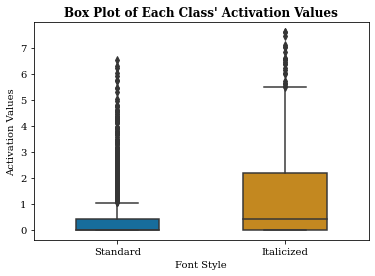

In [ ]:
am.activations_boxplot('act_val_10')

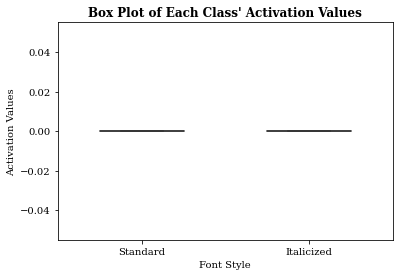

In [ ]:
am.activations_boxplot('act_val_100')

This sampling of boxplots of activation values for Nodes 0, 10, and 100 speak to the relative sparsity of the activation values. Node 0 is activated, but only infrequently, while Node 100 is not activated at all. A reduction in the nubmer of hidden units in the model might serve performance well then considering some of these units are not even used.

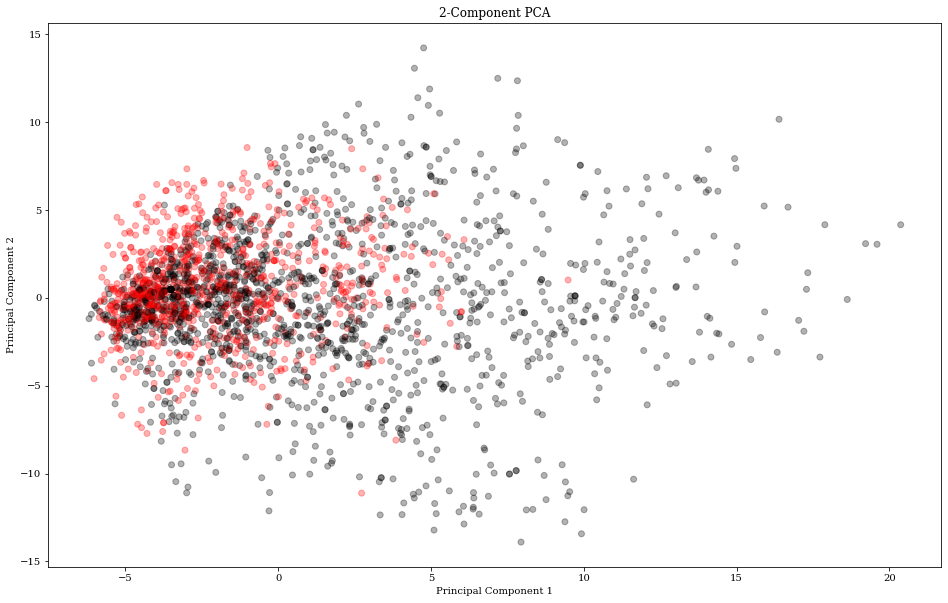

In [ ]:
am.activations_pca_plot(2)

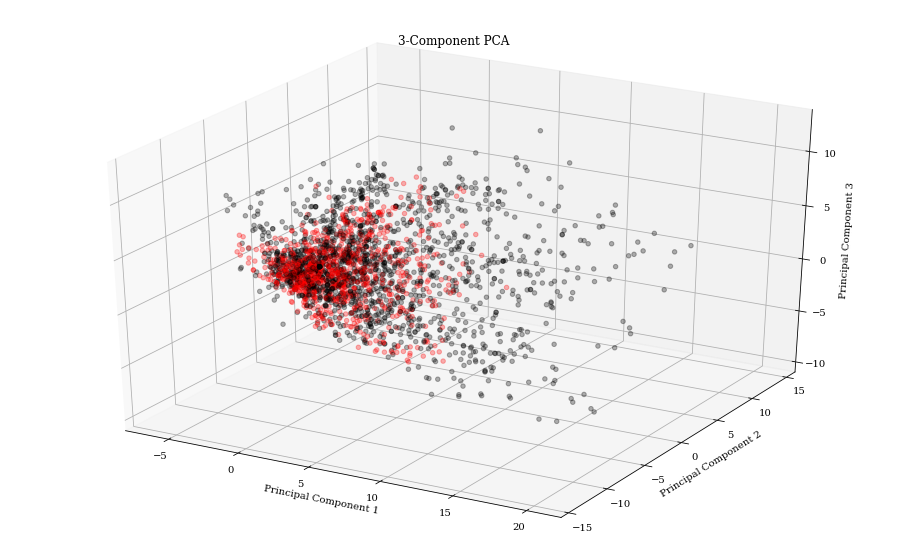

In [ ]:
am.activations_pca_plot(3)

The principal components plots of the model's activation values do not depict any clear separability between the two classes. The red class is quite concentrated in a single location on both plots, but the black class is rather spread out, overlapping frequently with the red class.

### Part 2

For this model, the number of hidden units in the single hidden layer is halved from 512 to 256.

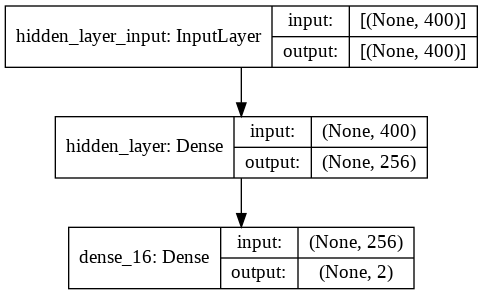

In [ ]:
model_3_2 = tf.keras.Sequential([
                             tf.keras.layers.Dense(256, activation='relu', input_shape=(400,), name='hidden_layer'),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model_3_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model_3_2, show_shapes=True)

In [ ]:
history = model_3_2.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.2, verbose=False)
preds = [np.argmax(p) for p in model_3_2.predict(X_test)]
loss, accuracy = model_3_2.evaluate(X_test, y_test)
print(f'Test Set Accuracy: {round(accuracy*100, 2)}')

80/80 [==============================] - 0s 1ms/step - loss: 0.3440 - accuracy: 0.9077
Test Set Accuracy: 90.77


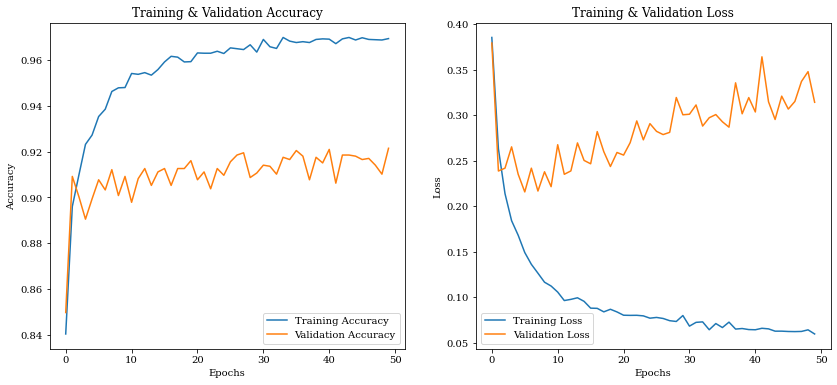

In [ ]:
fit_plots(history)

The reduction to 256 hidden units from 512 has done little to help the model's performance. The test set accuracy in fact decreased following this dip in capacity, and the overfitting issue quite seriously persists. From the loss plot, it look as if the overfitting has been delayed until the 5th epoch, but the problem is still obvious.  

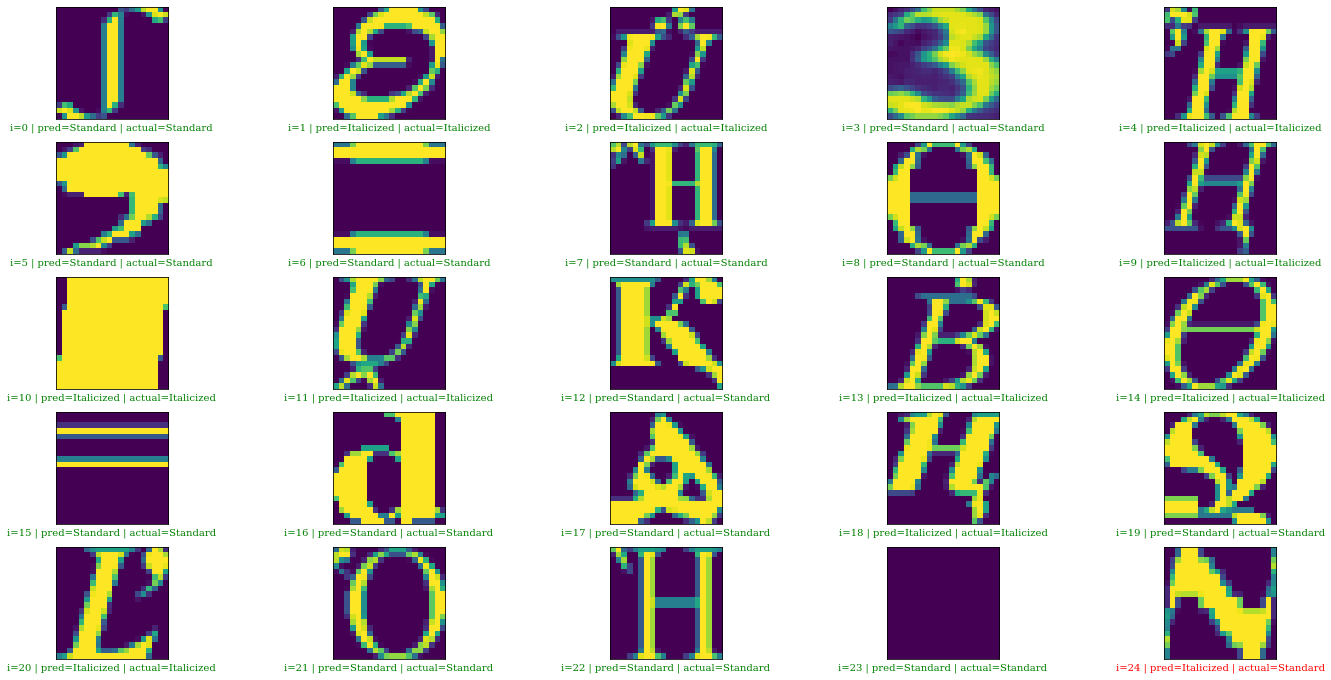

In [ ]:
plot_results(preds, y_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1551
           1       0.91      0.85      0.88       995

    accuracy                           0.91      2546
   macro avg       0.91      0.90      0.90      2546
weighted avg       0.91      0.91      0.91      2546



Just as before, the model has struggled to classify Image 24 correctly. The model's precision and recall scores remain relatively consistent with those from the previous model, so it cannot be concluded that a reduction in capacity has hindered the model's learning all that much.

In [ ]:
am = activation_model(model_3_2, preds, X_test, 256)
am.max_activations()

The maximum activation value of the hidden node(s) in the hidden layer is 11.381526947021484.
Percentage of Nodes Most Activated by Standard Class  : 97.35
Percentage of Nodes Most Activated by Italicized Class: 2.65


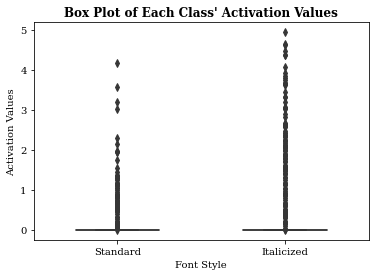

In [ ]:
am.activations_boxplot('act_val_0')

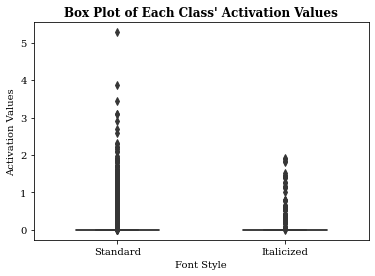

In [ ]:
am.activations_boxplot('act_val_10')

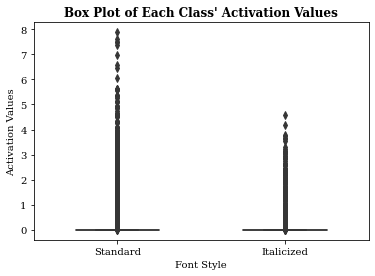

In [ ]:
am.activations_boxplot('act_val_100')

Quite clearly, the model tends to be activated more by images in the *Standard* class. The above boxplots also now all contain positive activation values, suggesting that there could be fewer unused nodes in the model's hidden layer. 

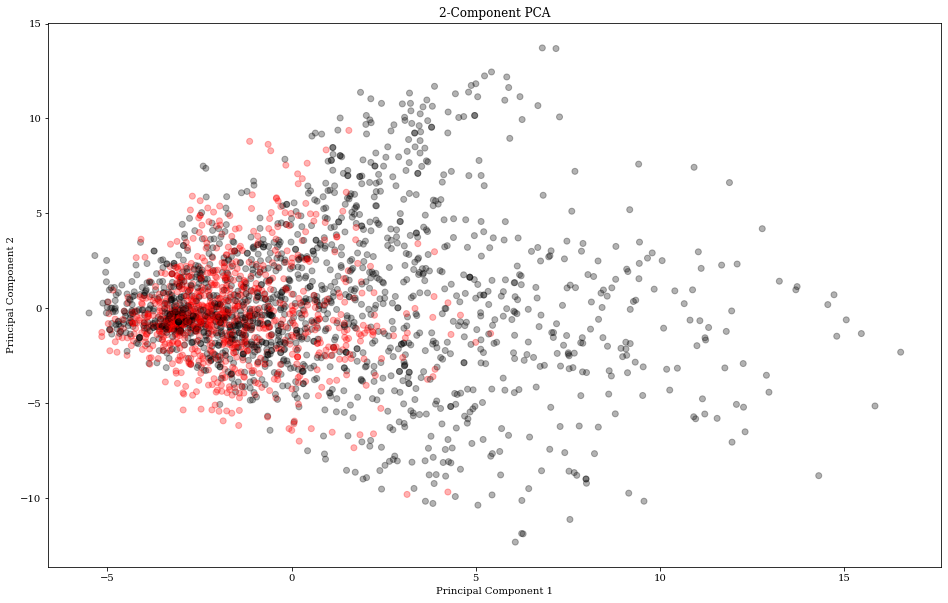

In [ ]:
am.activations_pca_plot(2)

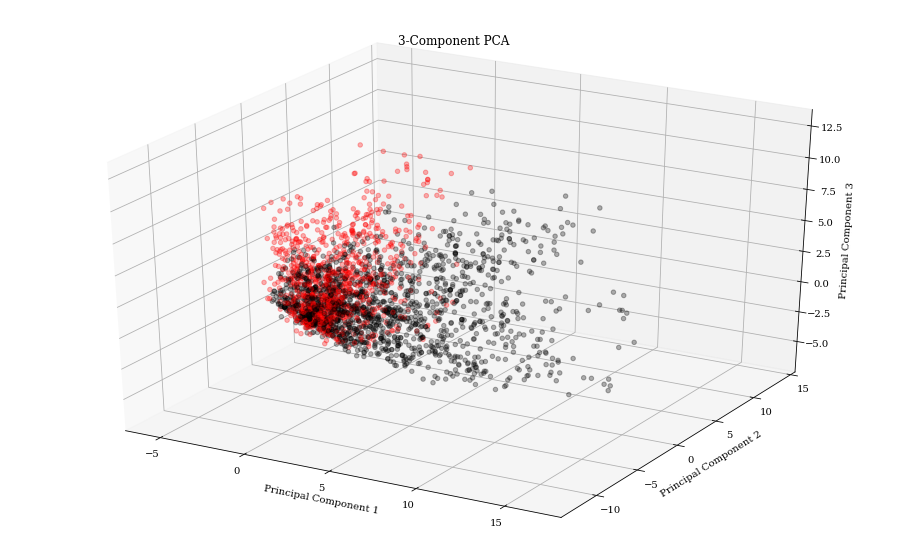

In [ ]:
am.activations_pca_plot(3)

These PCA plots show much of the same overlap problem as their previous versions, but perhaps to an even greater extent here. While the spread of the black class has remained the same, the red class is a bit less concentrated than it had been before, leading to a more nebulous decision boundary, at least in the case of two or three dimensions.

### Part 3

Again, the model's number of hidden units is halved, this time from 256 to 128.

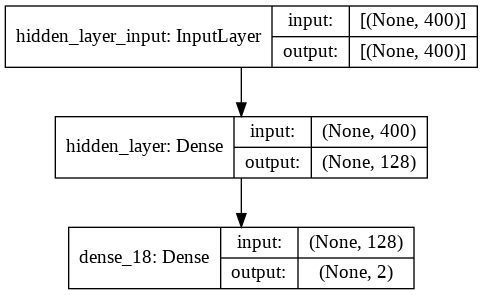

In [ ]:
model_3_3 = tf.keras.Sequential([
                             tf.keras.layers.Dense(128, activation='relu', input_shape=(400,), name='hidden_layer'),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model_3_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model_3_3, show_shapes=True)

In [ ]:
history = model_3_3.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.2, verbose=False)
preds = [np.argmax(p) for p in model_3_3.predict(X_test)]
loss, accuracy = model_3_3.evaluate(X_test, y_test)
print(f'Test Set Accuracy: {round(accuracy*100, 2)}')

80/80 [==============================] - 0s 1ms/step - loss: 0.3003 - accuracy: 0.9089
Test Set Accuracy: 90.89


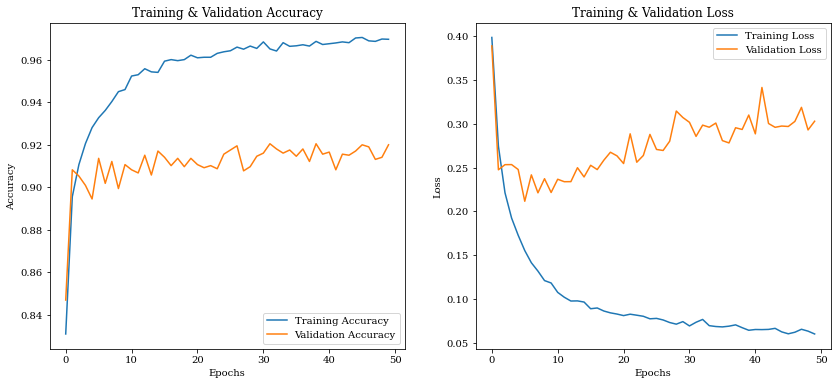

In [ ]:
fit_plots(history)

As was the case before, the decrease in the number of hidden units in the model's single hidden layer poses no significant threat to the model's predictive power. Albeit by only 0.12%, the test set accuracy of the model does actually increase. Still, overfitting runs rampant and is as always almost instantaneous once training starts.

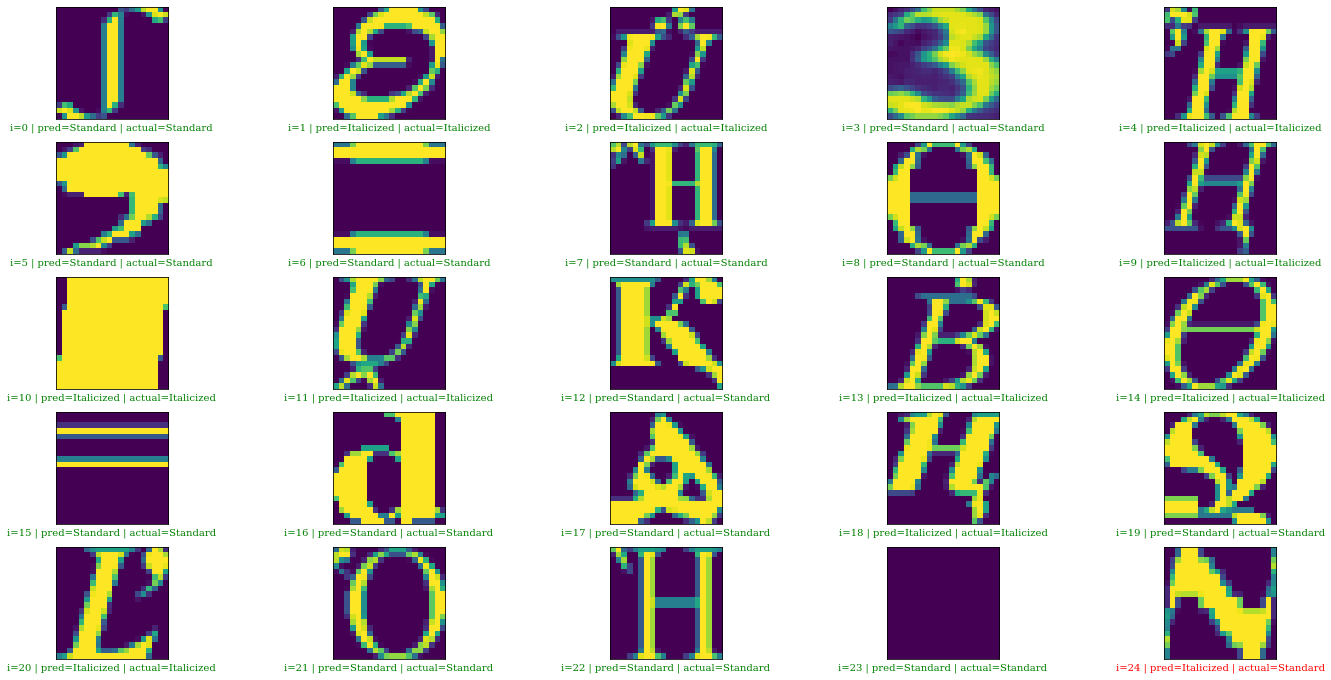

In [ ]:
plot_results(preds, y_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1551
           1       0.89      0.87      0.88       995

    accuracy                           0.91      2546
   macro avg       0.91      0.90      0.90      2546
weighted avg       0.91      0.91      0.91      2546



The only noticeable difference between this model and the previous iteration can be found in the precision and recall scores of the *Italicized* class. Here, the precision has dropped just a bit, but coincidentally, the recall has improved by about the same margin. Although the F1-scores with respect to this class are the same for both models, the model here might actually be a little better balanced.

In [ ]:
am = activation_model(model_3_3, preds, X_test, 128)
am.max_activations()

The maximum activation value of the hidden node(s) in the hidden layer is 11.423238754272461.
Percentage of Nodes Most Activated by Standard Class  : 94.74
Percentage of Nodes Most Activated by Italicized Class: 5.26


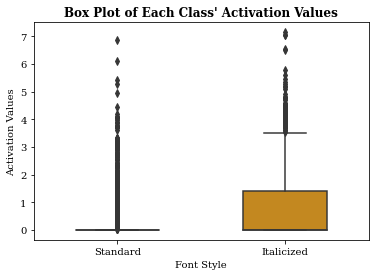

In [ ]:
am.activations_boxplot('act_val_0')

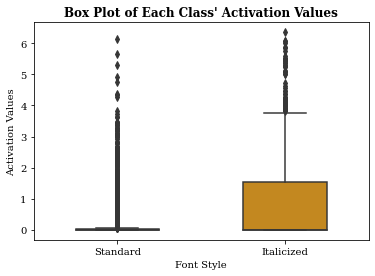

In [ ]:
am.activations_boxplot('act_val_10')

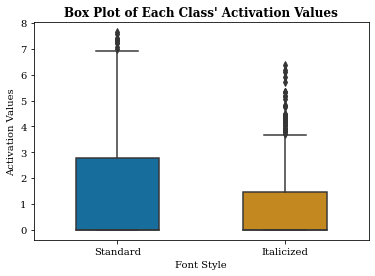

In [ ]:
am.activations_boxplot('act_val_100')

The decrease in the proportion of unactivated nodes seems to continue here, as the boxplots above demonstrate far more activity in the respective nodes than has been demonstrated previously. There have also started to be nodes more activated by the *Italicized* class than by the *Standard* class, indicating that the model might be doing a better job of learning the features associated with images in the former. 

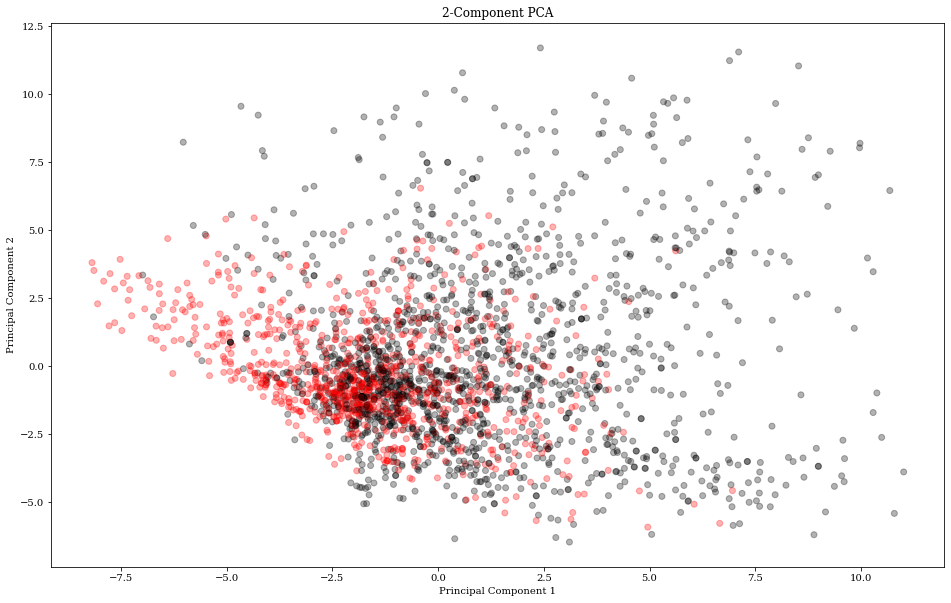

In [ ]:
am.activations_pca_plot(2)

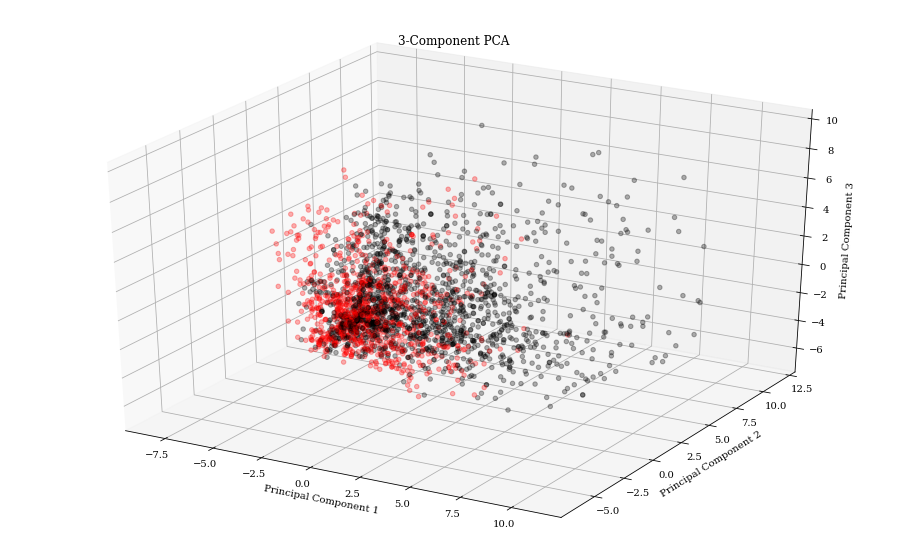

In [ ]:
am.activations_pca_plot(3)

Though the two-dimensional PCA plot doesn't reveal all that much with respect to a decision boundary, the three-dimensional plot does offer some indication of where a decision boundary may lie. The red points are mostly aggregated in the bottom left corner of the plot, while the black points sit atop them and more towards the center of the plot. Of the three sets of PCA plots generated thus far, this is the first to reveal a partly noticeable separation between the classes.

### Part 4

This model halves the number of hidden units in the single hidden layer from 128 to 64.

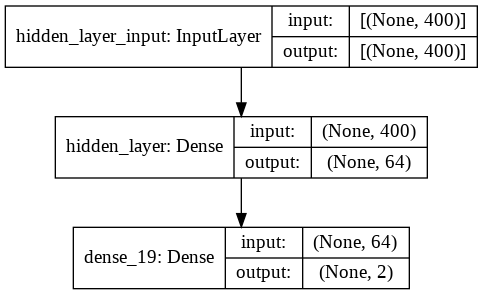

In [ ]:
model_3_4 = tf.keras.Sequential([
                             tf.keras.layers.Dense(64, activation='relu', input_shape=(400,), name='hidden_layer'),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model_3_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model_3_4, show_shapes=True)

In [ ]:
history = model_3_4.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.2, verbose=False)
preds = [np.argmax(p) for p in model_3_4.predict(X_test)]
loss, accuracy = model_3_4.evaluate(X_test, y_test)
print(f'Test Set Accuracy: {round(accuracy*100, 2)}')

80/80 [==============================] - 0s 1ms/step - loss: 0.3184 - accuracy: 0.9085
Test Set Accuracy: 90.85


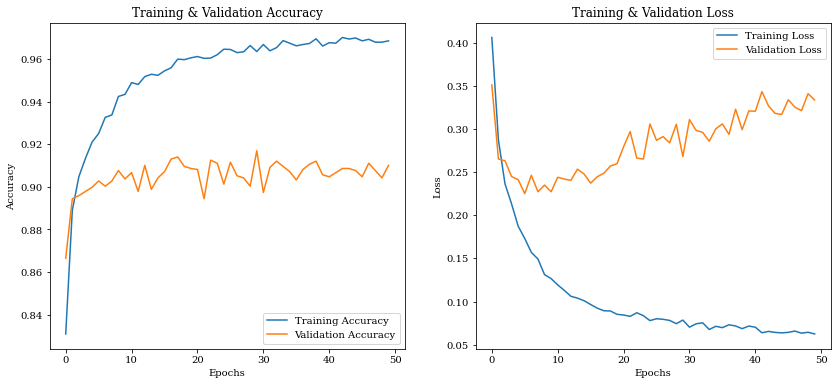

In [ ]:
fit_plots(history)

Once again, the model's test accuracy is maintained, despite a decrease in the model's capacity. The overfitting problem is still real, but the loss plot seems to show that the validation loss bottoms out closer to the 10th epoch than any of the previous models in this section.

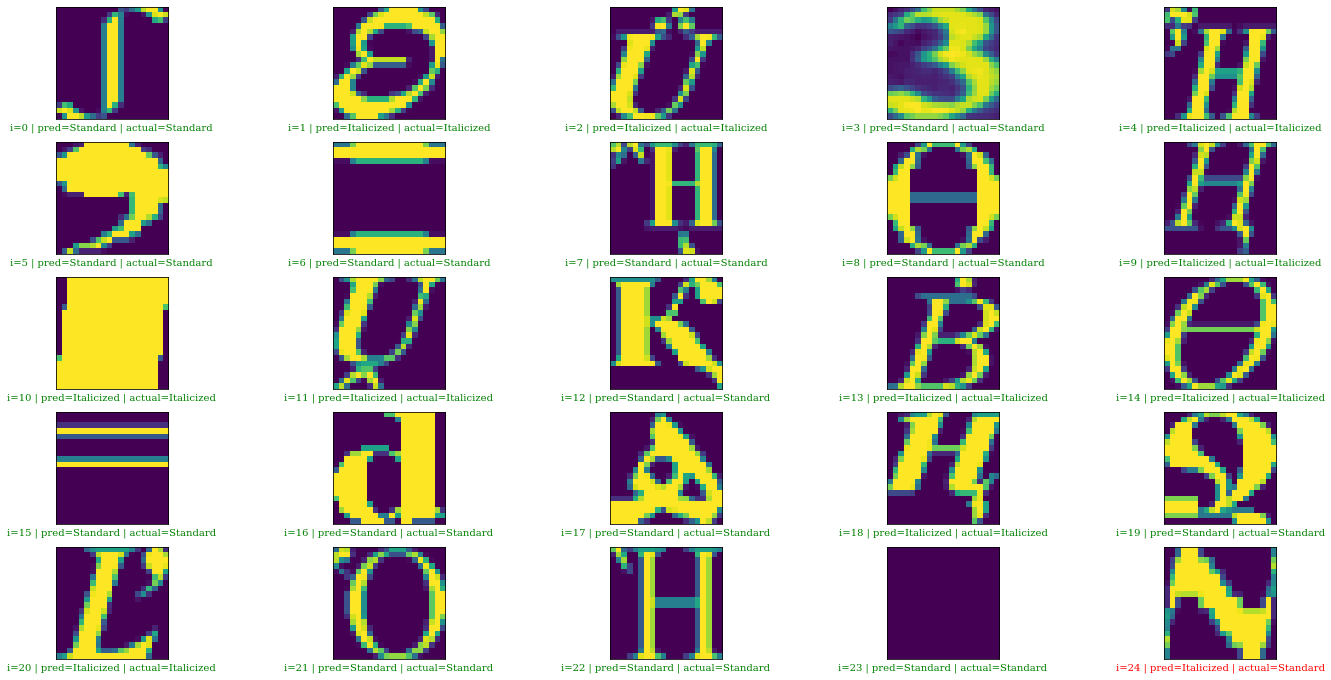

In [ ]:
plot_results(preds, y_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1551
           1       0.89      0.87      0.88       995

    accuracy                           0.91      2546
   macro avg       0.91      0.90      0.90      2546
weighted avg       0.91      0.91      0.91      2546



The classification results here are identical to those of the previous section, suggesting that nothing has been lost by decreasing the number of nodes in the model's single hidden layer.

In [ ]:
am = activation_model(model_3_4, preds, X_test, 64)
am.max_activations()

The maximum activation value of the hidden node(s) in the hidden layer is 10.332744598388672.
Percentage of Nodes Most Activated by Standard Class  : 86.84
Percentage of Nodes Most Activated by Italicized Class: 13.16


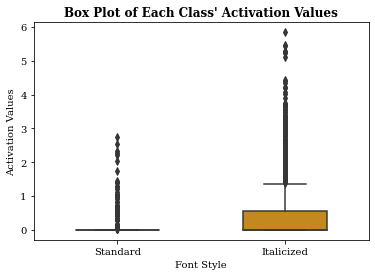

In [ ]:
am.activations_boxplot('act_val_0')

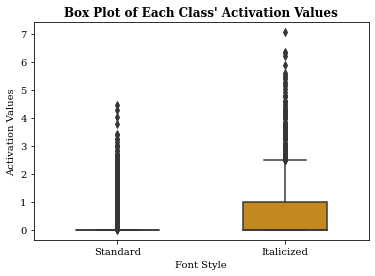

In [ ]:
am.activations_boxplot('act_val_10')

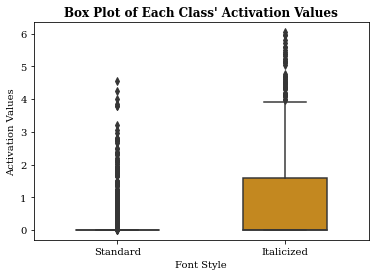

In [ ]:
am.activations_boxplot('act_val_63')

Just like the previous iteration of the model, this model appears to be learning the *Italicized* class' features better than before. Whereas the model in Part 1 of this section did not have a single node more activated by the *Italicized* class than the *Standard* class, 13% of the nodes in this model's single hidden layer are most activated by the *Italicized* class, three of which are illustrated in the boxplots above.

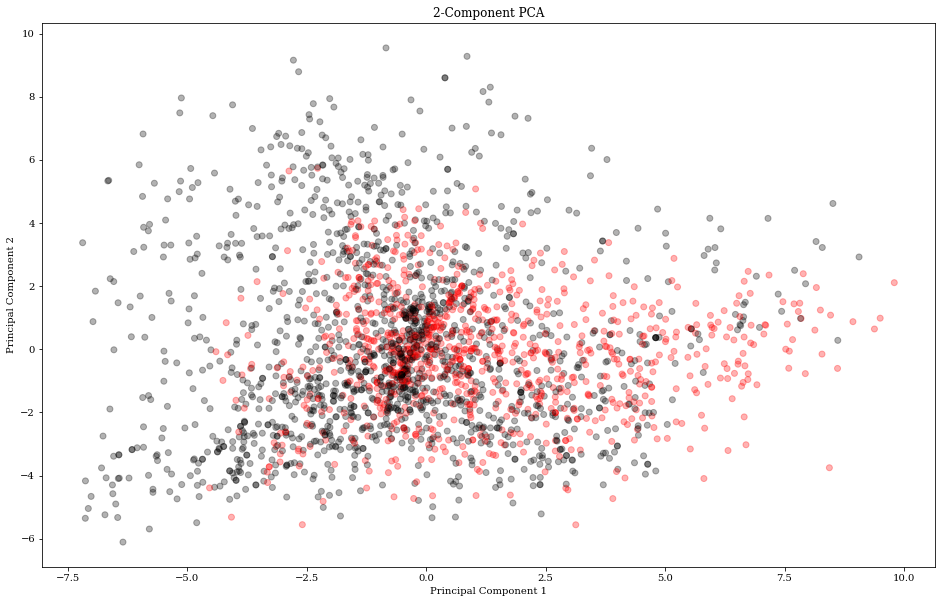

In [ ]:
am.activations_pca_plot(2)

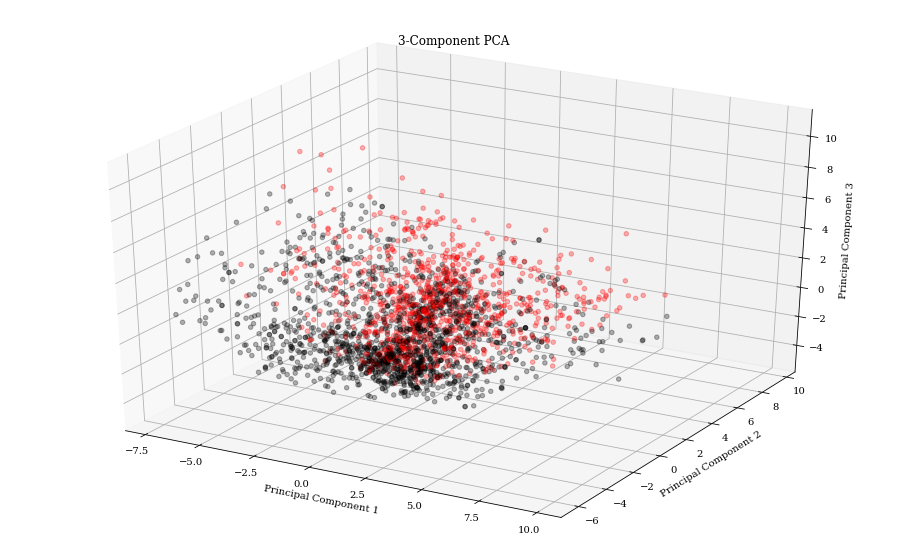

In [ ]:
am.activations_pca_plot(3)

Though not entirely clear in the 2D plot, the 3D PCA plot seems to be showing the decision boundary's becoming more defined. Much of this definition looks to be dependent upon the third principal component. There are essentially two fairly concentrated clusters of points in the plot, with the red cluster's sitting atop the black cluster. The density of these clusters, as indicated by darker colors, speaks to the quality of their separation, and therefore, the quality and consistency of the model's classifications. 

### Part 5

This last model in Section 3 reduces the number of hidden units in the model's single hidden layer to 32.

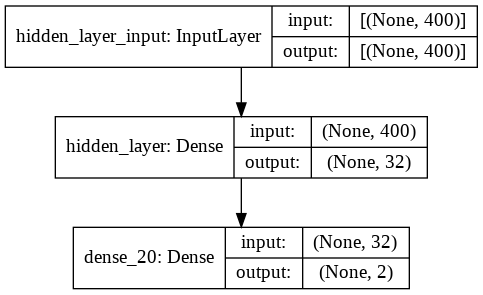

In [ ]:
model_3_5 = tf.keras.Sequential([
                             tf.keras.layers.Dense(32, activation='relu', input_shape=(400,), name='hidden_layer'),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model_3_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model_3_5, show_shapes=True)

In [ ]:
history = model_3_5.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.2, verbose=False)
preds = [np.argmax(p) for p in model_3_5.predict(X_test)]
loss, accuracy = model_3_5.evaluate(X_test, y_test)
print(f'Test Set Accuracy: {round(accuracy*100, 2)}')

80/80 [==============================] - 0s 1ms/step - loss: 0.3276 - accuracy: 0.9069
Test Set Accuracy: 90.69


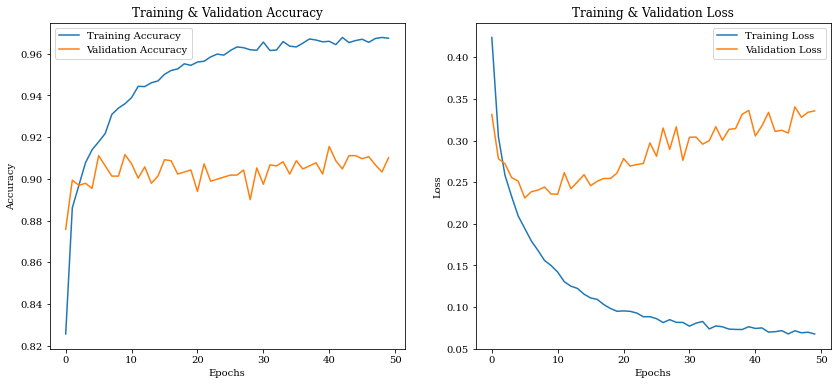

In [ ]:
fit_plots(history)

As has been the case throughout this section, the reduction in the number of hidden units in the model's single hidden layer does little to affect the model's predictive power. The test set accuracy hovers around the 91% mark as it has over the last couple of iterations of this model.

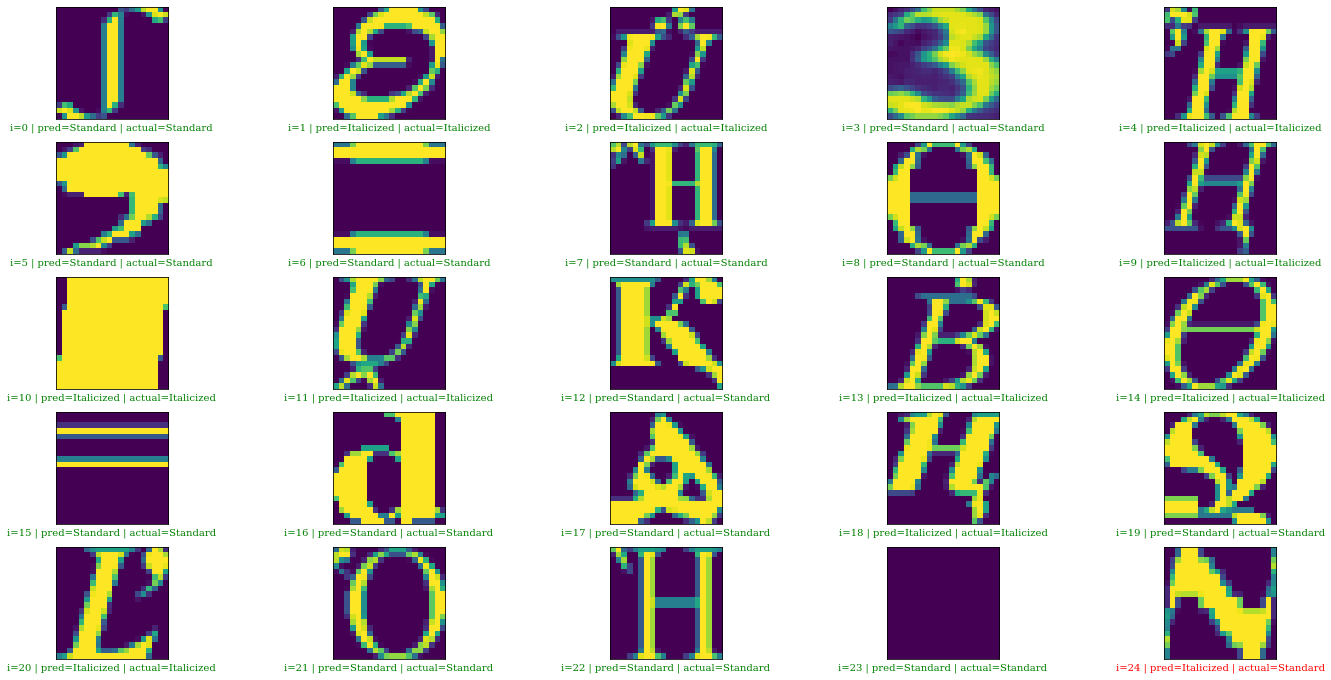

In [ ]:
plot_results(preds, y_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1551
           1       0.90      0.85      0.88       995

    accuracy                           0.91      2546
   macro avg       0.91      0.90      0.90      2546
weighted avg       0.91      0.91      0.91      2546



There is a minimal shift in the model's learning of the both classes, as made evident by the classification report above. The precision of the *Italicized* class has increased to 0.90, while the recall for this class has dropped back down to 0.85. The opposite has proved true for the *Standard* class, indicating that the model might be learning the idiosyncrasies of the *Standard* class to an unnecessary extent. This is most probably the result of decreased model capacity, which thereby has reduced the model's ability to effectively learn the features associated with both classes.  

In [ ]:
am = activation_model(model_3_5, preds, X_test, 32)
am.max_activations()

The maximum activation value of the hidden node(s) in the hidden layer is 10.5606050491333.
Percentage of Nodes Most Activated by Standard Class  : 100.0
Percentage of Nodes Most Activated by Italicized Class: 0.0


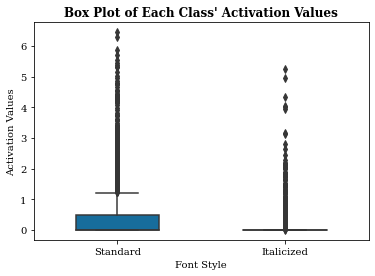

In [ ]:
am.activations_boxplot('act_val_0')

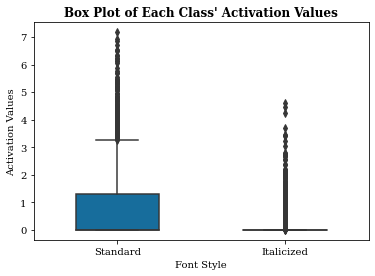

In [ ]:
am.activations_boxplot('act_val_10')

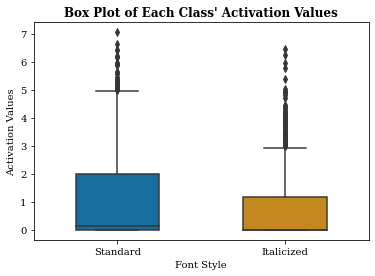

In [ ]:
am.activations_boxplot('act_val_31')

The model here has reverted to its previous state, wherein the activation values of its nodes were dominated by the *Standard* class. This, in concert with the classification report, perhaps points to a need for more model capacity. 

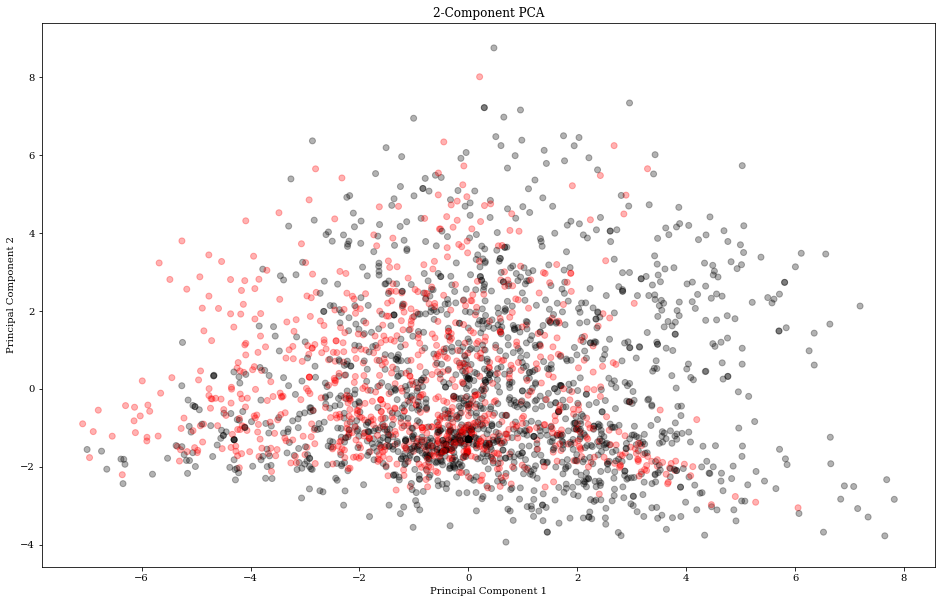

In [ ]:
am.activations_pca_plot(2)

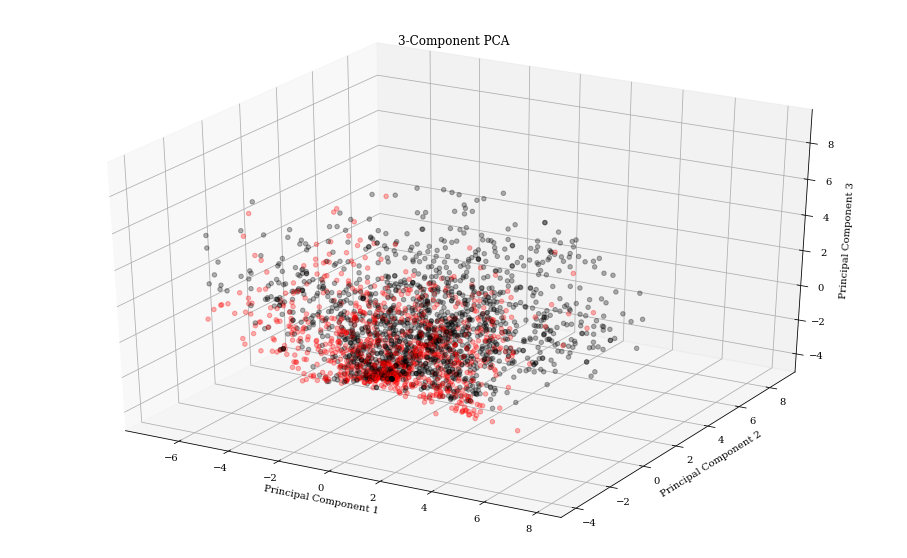

In [ ]:
am.activations_pca_plot(3)

Compared to the plots from the last part of this section, the plots here should a good deal more overlap between the two classes. While the red points in the 3D PCA plot are still pretty clustered, the black points are far more scattered, making the decision boundary between the two classes less clear. The architecture of the model by which the least obfuscated decision boundary has been determined - the model from Part 4 of Section 3 - will be used as the architectural foundation for this section.

## Section 4

This section of the notebook reduces the dimensionality of the data before model building, as opposed to after it. Principal components analysis is used to create a dataset of column vectors that accounts for 95% of the variance in the original dataset. The understanding is that this dimensionality reduction should quiet some of the noise in the data and thereby reduce the model's tendency to overfit.

In [ ]:
pca = PCA(.95)
X_train_pca = pca.fit_transform(X_train)
print(f'Training Set Shape: {X_train_pca.shape}')
X_test_pca = pca.transform(X_test)
print(f'Test Set Shape: {X_test_pca.shape}')

Training Set Shape: (10184, 130)
Test Set Shape: (2546, 130)


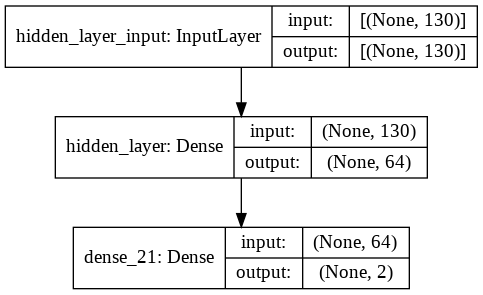

In [ ]:
model_pca = tf.keras.Sequential([
                             tf.keras.layers.Dense(64, activation='relu', input_shape=(130,), name='hidden_layer'),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model_pca.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model_pca, show_shapes=True)

In [ ]:
history = model_pca.fit(X_train_pca, y_train, batch_size=16, epochs=50, validation_split=0.2, verbose=False)
preds = [np.argmax(p) for p in model_pca.predict(X_test_pca)]
loss, accuracy = model_pca.evaluate(X_test_pca, y_test)
print(f'Test Set Accuracy: {round(accuracy*100, 2)}')

80/80 [==============================] - 0s 1ms/step - loss: 0.3349 - accuracy: 0.9006
Test Set Accuracy: 90.06


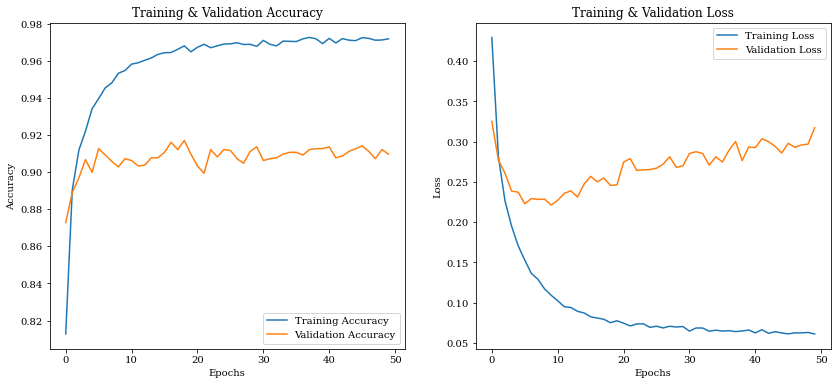

In [ ]:
fit_plots(history)

As is somewhat expected, the performance of the model on the test set decreases and by about 1%. The gap between training and validation accuracies and losses is not really reduced to the same extent, but it does appear that the model does not start to overfit until the 10th epoch, the longest such delay in overfitting yet.

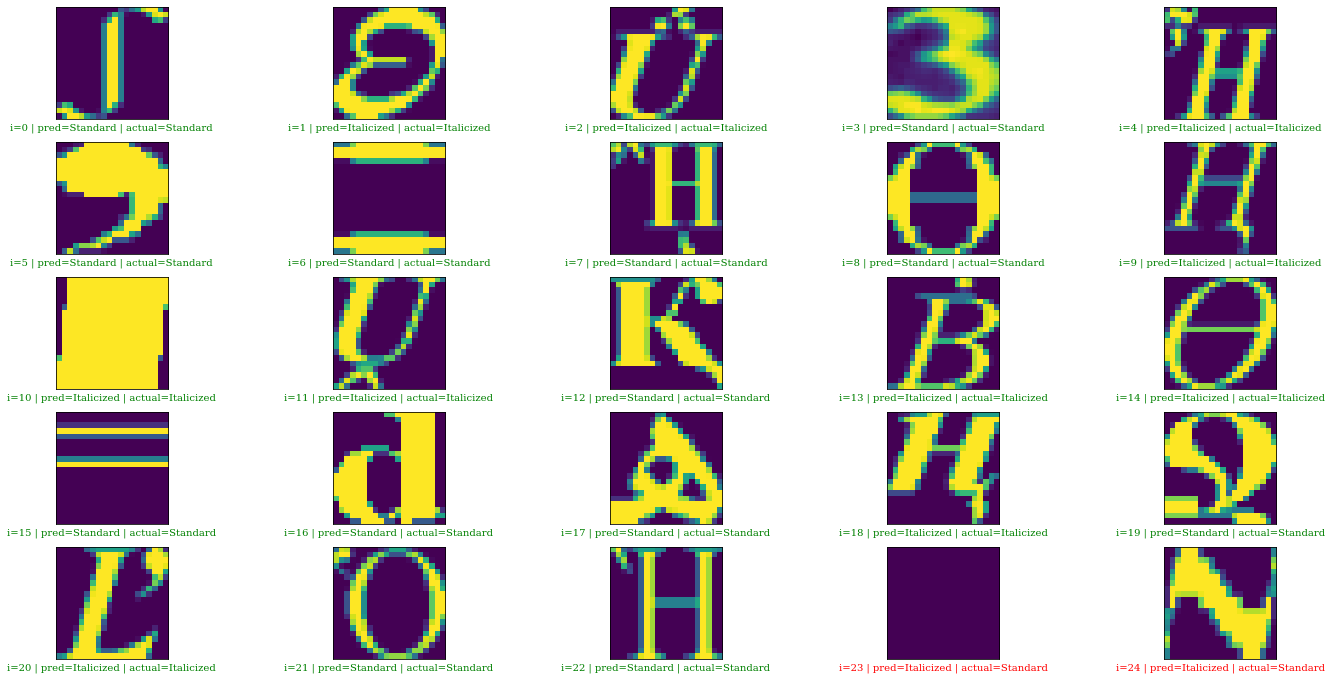

In [ ]:
plot_results(preds, y_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1551
           1       0.88      0.87      0.87       995

    accuracy                           0.90      2546
   macro avg       0.90      0.89      0.90      2546
weighted avg       0.90      0.90      0.90      2546



The dimensionality reduction of the input images appears to have affected the model's understanding of the *Italicized* class more substantially than it has affected the model's understanding of the *Standard* class, as both precision and recall of the *Italicized* class both fall below 90%.

In [ ]:
am = activation_model(model_pca, preds, X_test_pca, 64)
am.max_activations()

The maximum activation value of the hidden node(s) in the hidden layer is 7.158926963806152.
Percentage of Nodes Most Activated by Standard Class  : 60.71
Percentage of Nodes Most Activated by Italicized Class: 39.29


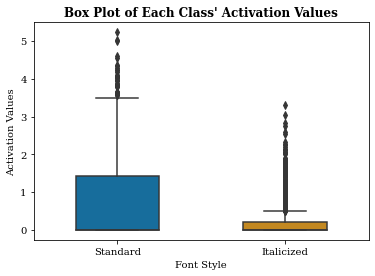

In [ ]:
am.activations_boxplot('act_val_0')

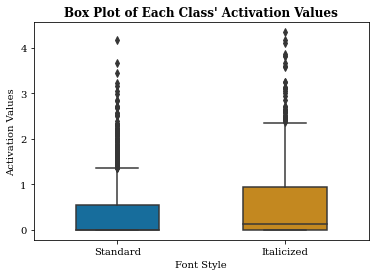

In [ ]:
am.activations_boxplot('act_val_10')

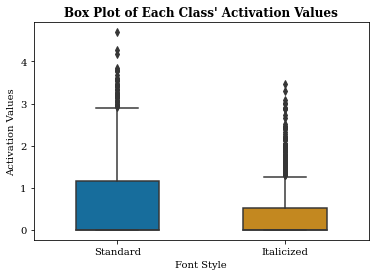

In [ ]:
am.activations_boxplot('act_val_63')

What is most interesting about these box plots and the above node percentages is the relative balance that has not been seen previously in any of these models. The reduction in image dimensionality appears to have had a substantial impact on the way that model learns the features associated with the *Italicized* class, resulting in a far greater percentage of nodes being more activated by this class than in previous sections.

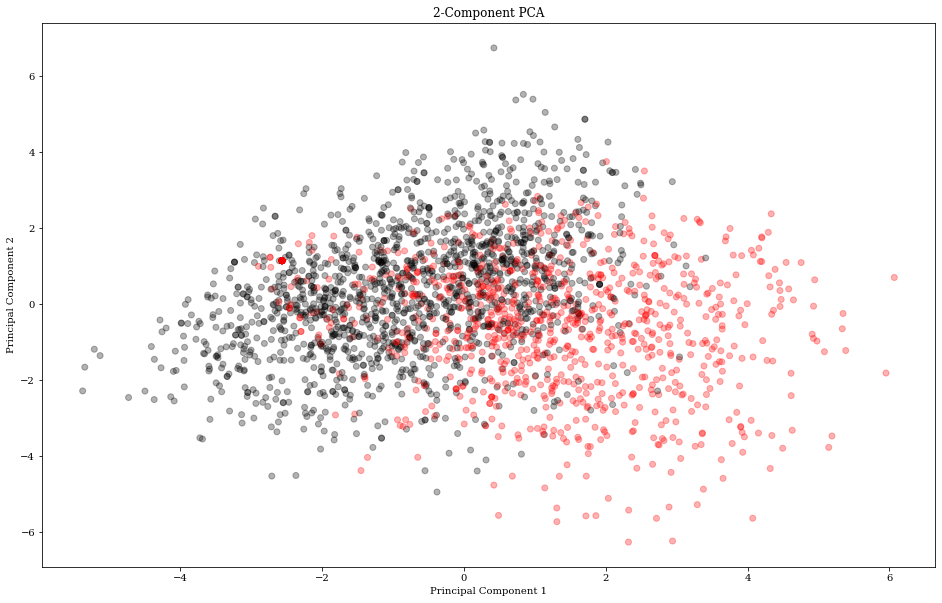

In [ ]:
am.activations_pca_plot(2)

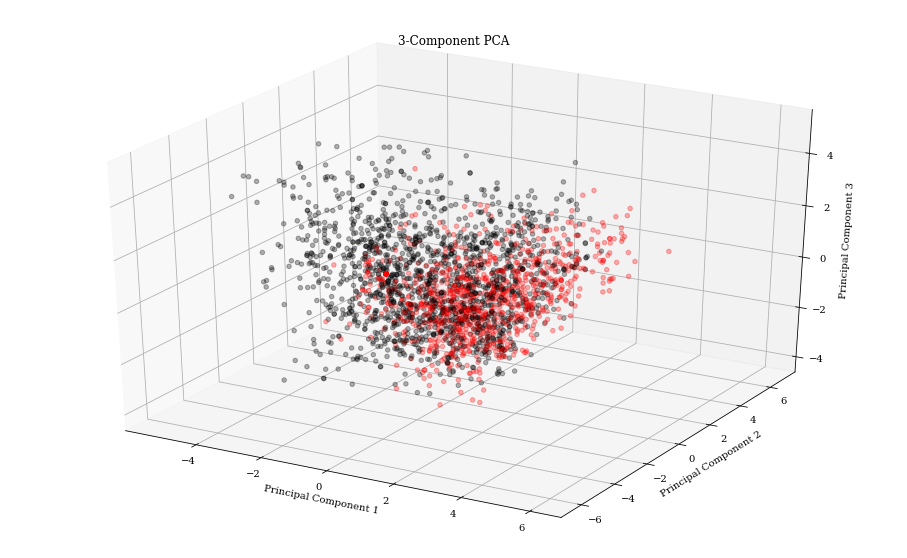

In [ ]:
 am.activations_pca_plot(3)

These two plots depict what amounts to the clearest decision boundary between classes seen thus far, especially in the case of the two-dimensional PCA plot. While there is still considerable overlap between the red and black points, the 2D plot marks the first time that one half of the plot has been dominated by one class while the other half of the plot has been dominated by the other. Apparently, the PCA conducted on the input data has reduced the noise in the images to such an extent that the decision boundary has grown more obvious.  

## Section 5

In this final section, dimensionality reduction is conducted once again, but this time, it is done through the use of a random forest. A random forest classifier is first fit on the original data, and the resultant feature importances are extracted from this fit. The 70 largest of these feature importances are then used to reduce the input data to those 70 pixel locations, with another neural network's being fit on the reduced data thereafter.

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 1031)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1031,
                       verbose=0, warm_start=False)

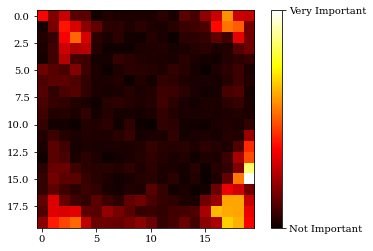

In [ ]:
# plotting feature importances for the 400 pixels in an image 
plot_heat_char(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks = [rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not Important', 'Very Important'])
plt.show()

The heat map shows that the most important pixel locations when it comes to determining whether or not a character is *Italicized* reside in the four corners of the image. This does seem to make a good amount of sense in that while both classes of font tend to occupy the center of the image, only italicized characters will have larger pixel values towards the edges of the image.

Redcued Training Set Shape: (10184, 70)
Redcued Test Set Shape: (2546, 70)




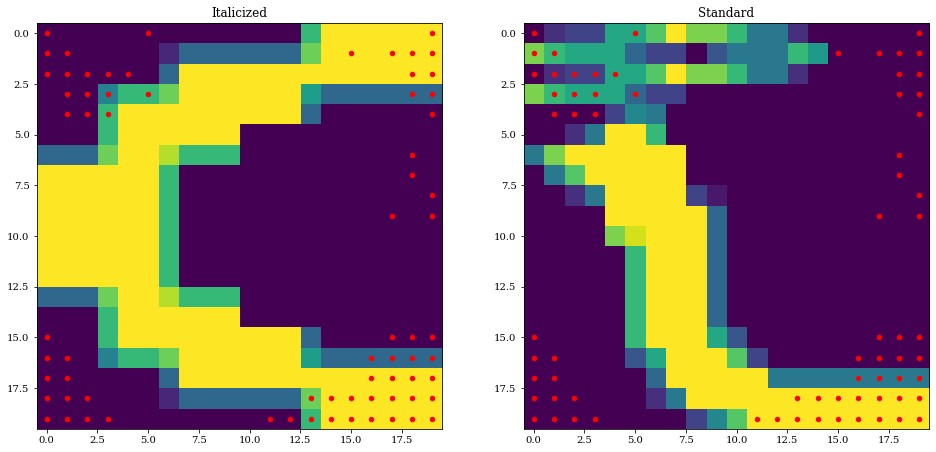

In [ ]:
# extracting the top 70 most significant pixel locations
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]
train_images_sm = X_train[:,idx]
test_images_sm = X_test[:,idx]
print(f'Redcued Training Set Shape: {train_images_sm.shape}')
print(f'Redcued Test Set Shape: {test_images_sm.shape}\n\n')

# plotting an example image with these locations identified
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

axs[0].imshow(np.array(X_train[3,:]).reshape(20,20))
x, y = np.array([pair(k,20) for k in idx]).T
axs[0].scatter(x,y,color='red',s=20)
t = 'Italicized' if y_train[3] == 1 else 'Standard'
_ = axs[0].set_title(t)


axs[1].imshow(np.array(X_train[1,:]).reshape(20,20))
x, y = np.array([pair(k,20) for k in idx]).T
axs[1].scatter(x,y,color='red',s=20)
t = 'Italicized' if y_train[1] == 1 else 'Standard'
_ = axs[1].set_title(t)

With respect to these 70 pixel locations, the main difference between the *Italicized* and *Standard* images above seems to come in the top left and right corners of the plots. Whereas the plot of the *Italicized* image occupies the top right pixel locations and not the top left, the *Standard* image does the exact opposite.

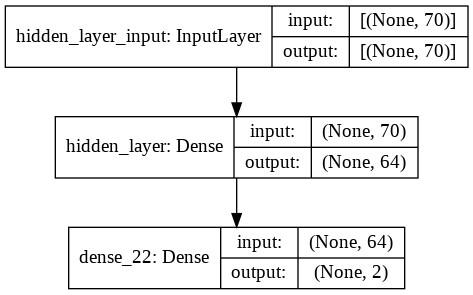

In [ ]:
model_rf = tf.keras.Sequential([
                             tf.keras.layers.Dense(64, activation='relu', input_shape=(70,), name='hidden_layer'),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model_rf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model_rf, show_shapes=True)

In [ ]:
history = model_rf.fit(train_images_sm, y_train, batch_size=16, epochs=50, validation_split=0.2, verbose=False)
preds = [np.argmax(p) for p in model_rf.predict(test_images_sm)]
loss, accuracy = model_rf.evaluate(test_images_sm, y_test)
print(f'Test Set Accuracy: {round(accuracy*100, 2)}')

80/80 [==============================] - 0s 2ms/step - loss: 0.3344 - accuracy: 0.8641
Test Set Accuracy: 86.41


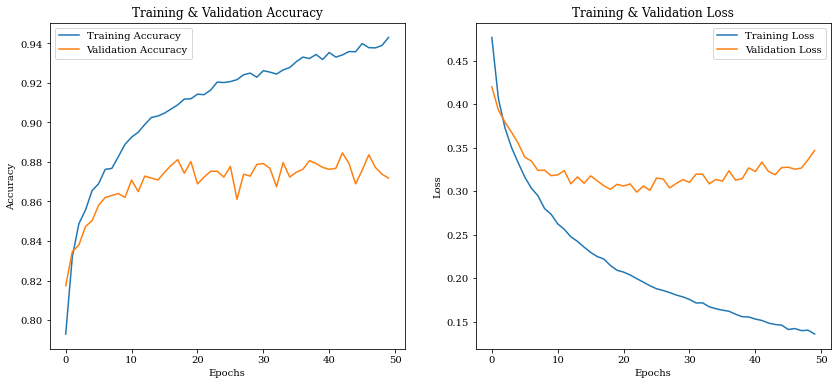

In [ ]:
fit_plots(history)

Though the model's test set accuracy falls well below the 90% mark to 86.41%, this seems to be more a case of drastic overfitting than anything else, especially when recognizing that the model's training accuracy neraly reaches that of the model in Part 1 of Section 3 that had 512 units in its hidden layer. Overfitting in terms of the model's loss does appear to be pushed beyond the 10th epoch, too, which perhaps suggests that regularization methods might prove fruitful in improving the model's test set performance.

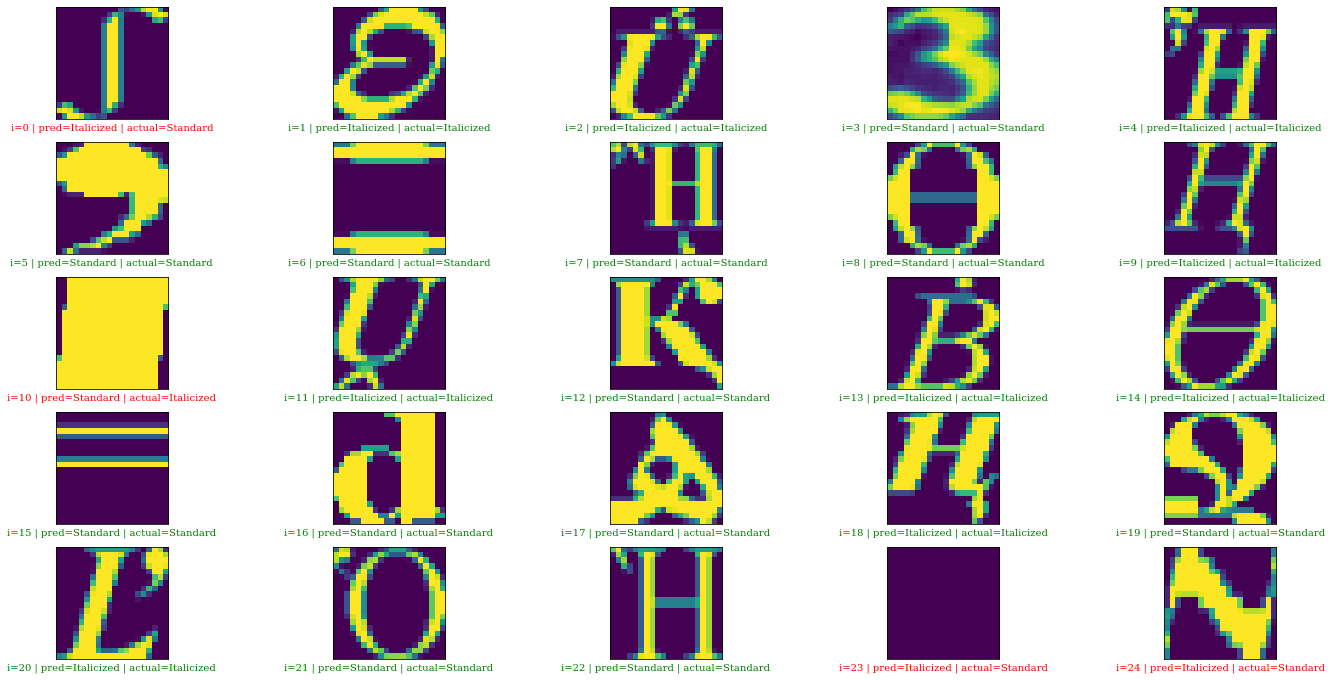

In [ ]:
plot_results(preds, y_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1551
           1       0.80      0.86      0.83       995

    accuracy                           0.86      2546
   macro avg       0.86      0.86      0.86      2546
weighted avg       0.87      0.86      0.86      2546



While the model's recall metrics do not fall off substantially, the model's precision with respect to the *Italicized* class decreases dramatically even though the *Standard* class precision pretty much stays put at 91%. This problem is further realized in the sample images above the classification report, in which three of the four incorrect predictions have actual *Standard* labels.

In [ ]:
am = activation_model(model_rf, preds, test_images_sm, 64)
am.max_activations()

The maximum activation value of the hidden node(s) in the hidden layer is 4.642745018005371.
Percentage of Nodes Most Activated by Standard Class  : 92.31
Percentage of Nodes Most Activated by Italicized Class: 7.69


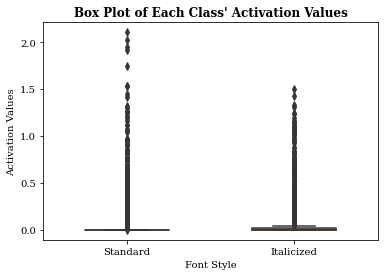

In [ ]:
am.activations_boxplot('act_val_0')

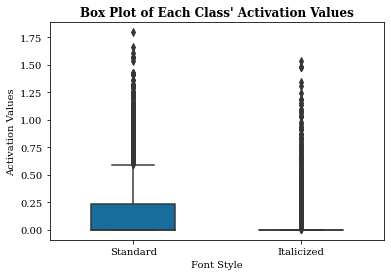

In [ ]:
am.activations_boxplot('act_val_10')

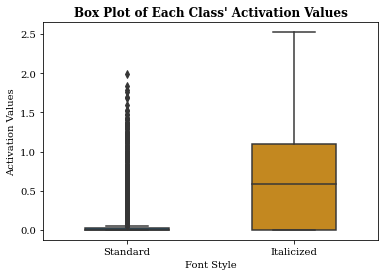

In [ ]:
am.activations_boxplot('act_val_63')

The box plots here appear to demonstrate some balance in the model's activation from both of the Font classes, but in reality, the model is far more activated by images in the *Standard* class than by images in the *Italicized* class, meaning that those pixel locations in the top left corner of the pixel grid are perhaps the most important locations in an image. 

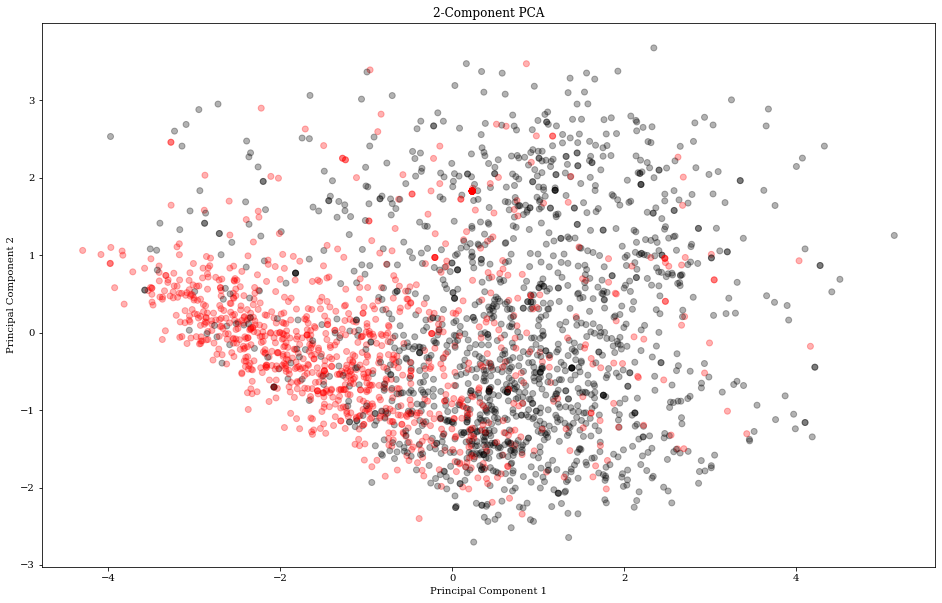

In [ ]:
am.activations_pca_plot(2)

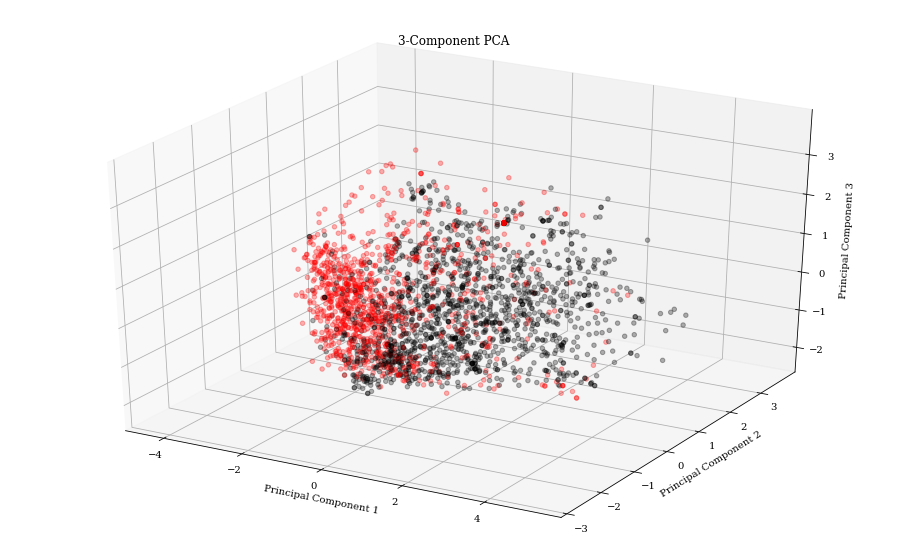

In [ ]:
am.activations_pca_plot(3)

Although the model's performance has dropped off considerably on the test set, the PCA plots here depict the clearest decision boundaries seen thus far. In the two-dimensional plot, the left side of the plot is mostly occupied by red points, and the right side of the plot is mostly occupied by black points. The separation becomes even clearer in the three-dimensional plot, suggesting that the random forest method of input dimensionality reduction best enables the model to understand the differences between the two classes. Further regularization methods when it comes to the model's training would likely improve the separability in these sorts of plots between the two classes.